# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

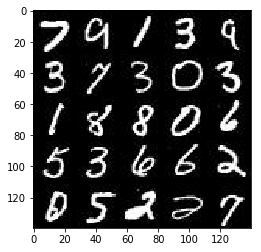

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

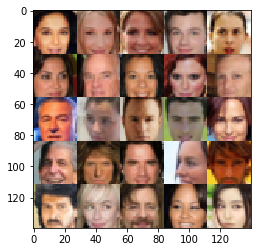

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_ = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='input_real')
    z_ = tf.placeholder(tf.float32,(None,z_dim),name='input_z')
    learning_rate_ = tf.placeholder(tf.float32,name='learning_rate')
    return input_, z_, learning_rate_



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def leaky_relu(x, alpha=0.1, name='leaky_relu'):
    return tf.maximum(x, alpha * x, name=name)


def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = leaky_relu(x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = leaky_relu(bn2)

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = leaky_relu(bn3)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        
        # Apply some dropout
        layer_dropout = tf.nn.dropout(flat, 0.7)
        
        logits = tf.layers.dense(layer_dropout, 1,
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        
                
        
        out = tf.sigmoid(logits)
        
        return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function

    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        # 7x7x512
        
        # Apply some dropout
        layer_dropout = tf.nn.dropout(x1, 0.5)        
        
        x2 = tf.layers.conv2d_transpose(layer_dropout, 256, 5, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        # 14x14x256

        # Apply some dropout
        layer_dropout1 = tf.nn.dropout(x2, 0.5)        
        
        
        x3 = tf.layers.conv2d_transpose(layer_dropout1, 128, 5, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        # 28x28x128

        # Apply some dropout
        layer_dropout2 = tf.nn.dropout(x3, 0.5)         
        
        # Output Layer
        logits = tf.layers.conv2d_transpose(layer_dropout2, out_channel_dim, 5, strides=1, padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3
        
        out = tf.tanh(logits)
        
        return out    



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    g_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')
    d_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')
    
    # Optimize
    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt    



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    #tf.reset_default_graph()
    # Create our input placeholders
    input_real, input_z, learning_rate_ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_, beta1)
    
    
    #saver = tf.train.Saver()
    #sample_z = np.random.uniform(-1, 1, size=(50, z_size))

    losses = []
    steps = 0   
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images *= 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               learning_rate_: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               learning_rate_: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images,                     
                                                input_z: batch_z,
                                                learning_rate_: learning_rate})
                    train_loss_g = g_loss.eval({input_real: batch_images,                     
                                                input_z: batch_z,
                                                learning_rate_: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 10, input_z, data_shape[3], data_image_mode)

        #saver.save(sess, './checkpoints/generator.ckpt')

    
    return losses                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5348... Generator Loss: 2.6785
Epoch 1/2... Discriminator Loss: 0.5996... Generator Loss: 2.4384
Epoch 1/2... Discriminator Loss: 1.3176... Generator Loss: 0.7691
Epoch 1/2... Discriminator Loss: 1.0149... Generator Loss: 1.2939
Epoch 1/2... Discriminator Loss: 0.6136... Generator Loss: 2.2232
Epoch 1/2... Discriminator Loss: 0.6322... Generator Loss: 2.5844
Epoch 1/2... Discriminator Loss: 0.7695... Generator Loss: 1.5678
Epoch 1/2... Discriminator Loss: 0.5562... Generator Loss: 3.0582
Epoch 1/2... Discriminator Loss: 0.7168... Generator Loss: 3.1720
Epoch 1/2... Discriminator Loss: 0.8818... Generator Loss: 1.2140


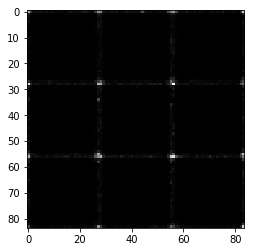

Epoch 1/2... Discriminator Loss: 1.2988... Generator Loss: 0.9567
Epoch 1/2... Discriminator Loss: 0.7115... Generator Loss: 1.8046
Epoch 1/2... Discriminator Loss: 0.9271... Generator Loss: 0.9369
Epoch 1/2... Discriminator Loss: 0.8454... Generator Loss: 2.7754
Epoch 1/2... Discriminator Loss: 0.5670... Generator Loss: 2.2010
Epoch 1/2... Discriminator Loss: 0.6703... Generator Loss: 2.5372
Epoch 1/2... Discriminator Loss: 0.7830... Generator Loss: 3.0465
Epoch 1/2... Discriminator Loss: 0.8063... Generator Loss: 1.7421
Epoch 1/2... Discriminator Loss: 0.6289... Generator Loss: 3.3029
Epoch 1/2... Discriminator Loss: 0.9036... Generator Loss: 1.4040


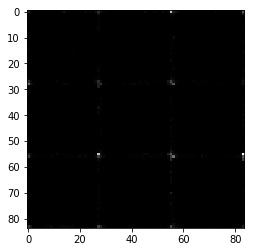

Epoch 1/2... Discriminator Loss: 0.6442... Generator Loss: 2.0491
Epoch 1/2... Discriminator Loss: 0.5960... Generator Loss: 1.9378
Epoch 1/2... Discriminator Loss: 0.5542... Generator Loss: 2.4864
Epoch 1/2... Discriminator Loss: 0.5919... Generator Loss: 3.8474
Epoch 1/2... Discriminator Loss: 0.5978... Generator Loss: 2.3544
Epoch 1/2... Discriminator Loss: 0.6942... Generator Loss: 1.9617
Epoch 1/2... Discriminator Loss: 0.6326... Generator Loss: 3.7059
Epoch 1/2... Discriminator Loss: 0.4873... Generator Loss: 2.7239
Epoch 1/2... Discriminator Loss: 0.6035... Generator Loss: 3.1436
Epoch 1/2... Discriminator Loss: 0.8011... Generator Loss: 1.5848


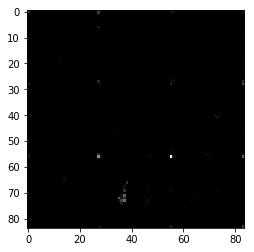

Epoch 1/2... Discriminator Loss: 0.7194... Generator Loss: 1.9539
Epoch 1/2... Discriminator Loss: 0.7564... Generator Loss: 2.2434
Epoch 1/2... Discriminator Loss: 0.5609... Generator Loss: 2.1922
Epoch 1/2... Discriminator Loss: 0.6686... Generator Loss: 1.4682
Epoch 1/2... Discriminator Loss: 0.4951... Generator Loss: 2.7829
Epoch 1/2... Discriminator Loss: 0.8732... Generator Loss: 1.4241
Epoch 1/2... Discriminator Loss: 1.0426... Generator Loss: 5.1887
Epoch 1/2... Discriminator Loss: 0.7382... Generator Loss: 1.9634
Epoch 1/2... Discriminator Loss: 0.6227... Generator Loss: 2.2821
Epoch 1/2... Discriminator Loss: 0.9856... Generator Loss: 1.2581


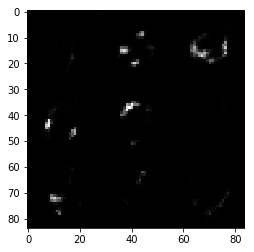

Epoch 1/2... Discriminator Loss: 0.7202... Generator Loss: 1.3374
Epoch 1/2... Discriminator Loss: 0.7168... Generator Loss: 2.2959
Epoch 1/2... Discriminator Loss: 0.7106... Generator Loss: 2.2027
Epoch 1/2... Discriminator Loss: 0.5441... Generator Loss: 3.3382
Epoch 1/2... Discriminator Loss: 0.6167... Generator Loss: 2.1891
Epoch 1/2... Discriminator Loss: 0.8059... Generator Loss: 3.2704
Epoch 1/2... Discriminator Loss: 1.3308... Generator Loss: 1.1076
Epoch 1/2... Discriminator Loss: 0.7145... Generator Loss: 1.9011
Epoch 1/2... Discriminator Loss: 0.6302... Generator Loss: 2.3912
Epoch 1/2... Discriminator Loss: 0.7154... Generator Loss: 1.9696


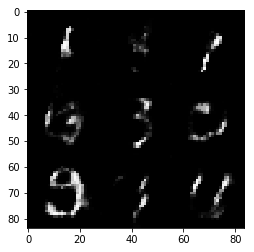

Epoch 1/2... Discriminator Loss: 0.6948... Generator Loss: 2.4310
Epoch 1/2... Discriminator Loss: 0.7420... Generator Loss: 2.3446
Epoch 1/2... Discriminator Loss: 0.7107... Generator Loss: 1.6362
Epoch 1/2... Discriminator Loss: 0.5852... Generator Loss: 2.8132
Epoch 1/2... Discriminator Loss: 0.7279... Generator Loss: 2.6857
Epoch 1/2... Discriminator Loss: 0.6065... Generator Loss: 2.3916
Epoch 1/2... Discriminator Loss: 0.7317... Generator Loss: 1.6418
Epoch 1/2... Discriminator Loss: 0.6832... Generator Loss: 1.9818
Epoch 1/2... Discriminator Loss: 0.8340... Generator Loss: 1.3148
Epoch 1/2... Discriminator Loss: 0.7132... Generator Loss: 2.4390


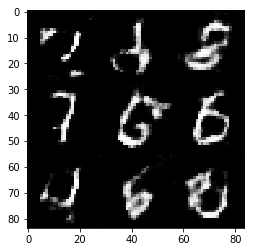

Epoch 1/2... Discriminator Loss: 0.6067... Generator Loss: 2.4588
Epoch 1/2... Discriminator Loss: 0.5860... Generator Loss: 2.8322
Epoch 1/2... Discriminator Loss: 0.7283... Generator Loss: 2.4020
Epoch 1/2... Discriminator Loss: 0.7417... Generator Loss: 2.7331
Epoch 1/2... Discriminator Loss: 1.0178... Generator Loss: 1.1651
Epoch 1/2... Discriminator Loss: 0.7965... Generator Loss: 1.4514
Epoch 1/2... Discriminator Loss: 0.5566... Generator Loss: 2.0507
Epoch 1/2... Discriminator Loss: 0.9366... Generator Loss: 1.1714
Epoch 1/2... Discriminator Loss: 0.8076... Generator Loss: 2.0621
Epoch 1/2... Discriminator Loss: 0.7640... Generator Loss: 2.4850


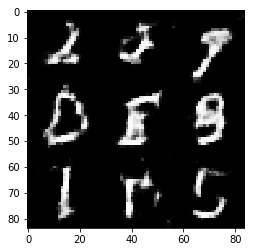

Epoch 1/2... Discriminator Loss: 0.6431... Generator Loss: 1.8473
Epoch 1/2... Discriminator Loss: 0.7901... Generator Loss: 1.5785
Epoch 1/2... Discriminator Loss: 0.7086... Generator Loss: 2.6307
Epoch 1/2... Discriminator Loss: 0.7883... Generator Loss: 1.8857
Epoch 1/2... Discriminator Loss: 0.6679... Generator Loss: 1.8812
Epoch 1/2... Discriminator Loss: 0.9072... Generator Loss: 2.5550
Epoch 1/2... Discriminator Loss: 0.6276... Generator Loss: 3.0658
Epoch 1/2... Discriminator Loss: 1.0768... Generator Loss: 1.1910
Epoch 1/2... Discriminator Loss: 0.6934... Generator Loss: 2.0041
Epoch 1/2... Discriminator Loss: 0.9698... Generator Loss: 1.0369


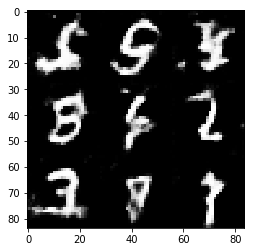

Epoch 1/2... Discriminator Loss: 1.3197... Generator Loss: 0.7711
Epoch 1/2... Discriminator Loss: 0.6525... Generator Loss: 2.6083
Epoch 1/2... Discriminator Loss: 0.7926... Generator Loss: 1.5388
Epoch 1/2... Discriminator Loss: 0.8976... Generator Loss: 1.1899
Epoch 1/2... Discriminator Loss: 0.6829... Generator Loss: 1.9312
Epoch 1/2... Discriminator Loss: 0.9656... Generator Loss: 1.0757
Epoch 1/2... Discriminator Loss: 0.5973... Generator Loss: 2.8804
Epoch 1/2... Discriminator Loss: 0.9010... Generator Loss: 2.7832
Epoch 1/2... Discriminator Loss: 0.5756... Generator Loss: 2.9444
Epoch 1/2... Discriminator Loss: 0.6216... Generator Loss: 1.3900


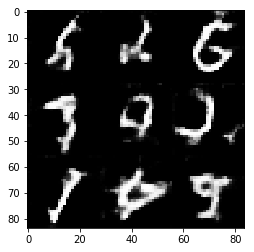

Epoch 1/2... Discriminator Loss: 0.6004... Generator Loss: 2.1591
Epoch 1/2... Discriminator Loss: 0.5650... Generator Loss: 2.1307
Epoch 1/2... Discriminator Loss: 0.7587... Generator Loss: 1.5936
Epoch 1/2... Discriminator Loss: 0.6987... Generator Loss: 2.1172
Epoch 1/2... Discriminator Loss: 0.6617... Generator Loss: 1.8777
Epoch 1/2... Discriminator Loss: 0.7383... Generator Loss: 1.6889
Epoch 1/2... Discriminator Loss: 0.8427... Generator Loss: 1.4610
Epoch 1/2... Discriminator Loss: 1.0439... Generator Loss: 0.9824
Epoch 1/2... Discriminator Loss: 0.7850... Generator Loss: 1.4671
Epoch 1/2... Discriminator Loss: 0.8289... Generator Loss: 1.6643


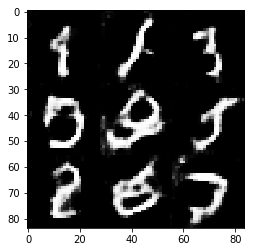

Epoch 1/2... Discriminator Loss: 0.6834... Generator Loss: 2.6421
Epoch 1/2... Discriminator Loss: 1.0601... Generator Loss: 2.6946
Epoch 1/2... Discriminator Loss: 0.7675... Generator Loss: 1.3916
Epoch 1/2... Discriminator Loss: 0.6605... Generator Loss: 2.2633
Epoch 1/2... Discriminator Loss: 0.6805... Generator Loss: 1.6877
Epoch 1/2... Discriminator Loss: 0.7262... Generator Loss: 1.6215
Epoch 1/2... Discriminator Loss: 0.7061... Generator Loss: 2.7587
Epoch 1/2... Discriminator Loss: 0.6385... Generator Loss: 2.0608
Epoch 1/2... Discriminator Loss: 0.7890... Generator Loss: 1.3923
Epoch 1/2... Discriminator Loss: 0.8252... Generator Loss: 1.9292


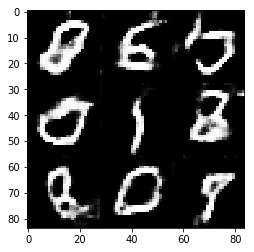

Epoch 1/2... Discriminator Loss: 0.9107... Generator Loss: 3.0584
Epoch 1/2... Discriminator Loss: 0.8435... Generator Loss: 1.5831
Epoch 1/2... Discriminator Loss: 0.6416... Generator Loss: 2.0351
Epoch 1/2... Discriminator Loss: 0.8580... Generator Loss: 1.4267
Epoch 1/2... Discriminator Loss: 0.5654... Generator Loss: 2.5980
Epoch 1/2... Discriminator Loss: 0.5822... Generator Loss: 2.2486
Epoch 1/2... Discriminator Loss: 0.8160... Generator Loss: 2.6592
Epoch 1/2... Discriminator Loss: 0.8211... Generator Loss: 2.3929
Epoch 1/2... Discriminator Loss: 0.6655... Generator Loss: 1.5343
Epoch 1/2... Discriminator Loss: 0.6120... Generator Loss: 2.3348


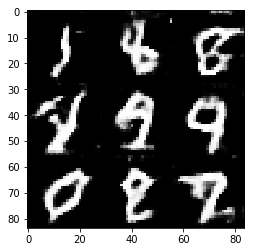

Epoch 1/2... Discriminator Loss: 0.9635... Generator Loss: 3.6082
Epoch 1/2... Discriminator Loss: 0.7080... Generator Loss: 1.7624
Epoch 1/2... Discriminator Loss: 0.6266... Generator Loss: 1.5125
Epoch 1/2... Discriminator Loss: 0.5330... Generator Loss: 2.6508
Epoch 1/2... Discriminator Loss: 0.6416... Generator Loss: 2.3277
Epoch 1/2... Discriminator Loss: 0.7252... Generator Loss: 2.5844
Epoch 1/2... Discriminator Loss: 0.7683... Generator Loss: 1.9630
Epoch 1/2... Discriminator Loss: 0.8680... Generator Loss: 3.2716
Epoch 1/2... Discriminator Loss: 0.6287... Generator Loss: 2.0037
Epoch 1/2... Discriminator Loss: 0.7747... Generator Loss: 2.9216


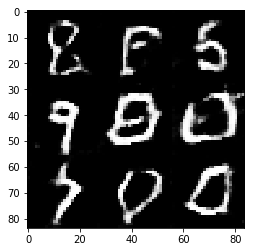

Epoch 1/2... Discriminator Loss: 1.0319... Generator Loss: 1.2766
Epoch 1/2... Discriminator Loss: 0.7094... Generator Loss: 2.6730
Epoch 1/2... Discriminator Loss: 0.6719... Generator Loss: 1.9452
Epoch 1/2... Discriminator Loss: 0.6699... Generator Loss: 2.0301
Epoch 1/2... Discriminator Loss: 0.8951... Generator Loss: 0.9859
Epoch 1/2... Discriminator Loss: 0.7960... Generator Loss: 1.4732
Epoch 1/2... Discriminator Loss: 0.6834... Generator Loss: 2.7790
Epoch 1/2... Discriminator Loss: 0.4614... Generator Loss: 2.9801
Epoch 1/2... Discriminator Loss: 0.8111... Generator Loss: 1.3426
Epoch 1/2... Discriminator Loss: 0.6168... Generator Loss: 1.8641


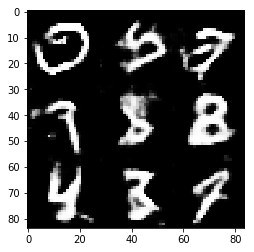

Epoch 1/2... Discriminator Loss: 0.6198... Generator Loss: 2.2216
Epoch 1/2... Discriminator Loss: 0.9955... Generator Loss: 3.3187
Epoch 1/2... Discriminator Loss: 0.6673... Generator Loss: 1.5786
Epoch 1/2... Discriminator Loss: 0.5728... Generator Loss: 2.4730
Epoch 1/2... Discriminator Loss: 0.7771... Generator Loss: 1.7120
Epoch 1/2... Discriminator Loss: 0.5836... Generator Loss: 2.2984
Epoch 1/2... Discriminator Loss: 0.5883... Generator Loss: 2.0490
Epoch 1/2... Discriminator Loss: 0.8076... Generator Loss: 1.8333
Epoch 1/2... Discriminator Loss: 0.7904... Generator Loss: 1.5866
Epoch 1/2... Discriminator Loss: 0.5788... Generator Loss: 2.3349


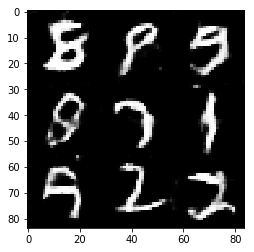

Epoch 1/2... Discriminator Loss: 0.5729... Generator Loss: 2.7857
Epoch 1/2... Discriminator Loss: 0.7107... Generator Loss: 2.1671
Epoch 1/2... Discriminator Loss: 0.5746... Generator Loss: 1.7907
Epoch 1/2... Discriminator Loss: 0.6437... Generator Loss: 2.2598
Epoch 1/2... Discriminator Loss: 0.8048... Generator Loss: 4.1321
Epoch 1/2... Discriminator Loss: 0.5712... Generator Loss: 2.2554
Epoch 1/2... Discriminator Loss: 0.5868... Generator Loss: 2.7116
Epoch 1/2... Discriminator Loss: 0.6534... Generator Loss: 1.7931
Epoch 1/2... Discriminator Loss: 0.5973... Generator Loss: 1.8818
Epoch 1/2... Discriminator Loss: 1.2782... Generator Loss: 3.8949


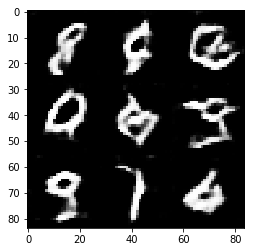

Epoch 1/2... Discriminator Loss: 0.6007... Generator Loss: 2.4534
Epoch 1/2... Discriminator Loss: 0.6193... Generator Loss: 1.9551
Epoch 1/2... Discriminator Loss: 0.5967... Generator Loss: 1.9751
Epoch 1/2... Discriminator Loss: 0.6634... Generator Loss: 1.5863
Epoch 1/2... Discriminator Loss: 0.5614... Generator Loss: 2.0163
Epoch 1/2... Discriminator Loss: 0.5881... Generator Loss: 2.1210
Epoch 1/2... Discriminator Loss: 0.7738... Generator Loss: 1.4825
Epoch 1/2... Discriminator Loss: 0.7065... Generator Loss: 1.5723
Epoch 1/2... Discriminator Loss: 0.6227... Generator Loss: 2.0870
Epoch 1/2... Discriminator Loss: 0.6912... Generator Loss: 2.2879


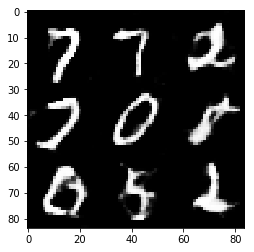

Epoch 1/2... Discriminator Loss: 0.6903... Generator Loss: 2.2959
Epoch 1/2... Discriminator Loss: 0.6574... Generator Loss: 2.1717
Epoch 1/2... Discriminator Loss: 0.6682... Generator Loss: 1.8764
Epoch 1/2... Discriminator Loss: 0.6493... Generator Loss: 3.8469
Epoch 1/2... Discriminator Loss: 0.5896... Generator Loss: 2.1829
Epoch 1/2... Discriminator Loss: 0.8748... Generator Loss: 1.6077
Epoch 1/2... Discriminator Loss: 0.5180... Generator Loss: 3.7319
Epoch 1/2... Discriminator Loss: 0.5662... Generator Loss: 2.6110
Epoch 1/2... Discriminator Loss: 0.5455... Generator Loss: 2.1205
Epoch 1/2... Discriminator Loss: 0.6751... Generator Loss: 1.9339


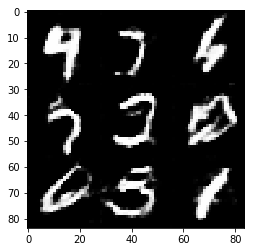

Epoch 1/2... Discriminator Loss: 0.5089... Generator Loss: 2.8171
Epoch 1/2... Discriminator Loss: 1.0987... Generator Loss: 0.8243
Epoch 1/2... Discriminator Loss: 0.5702... Generator Loss: 2.6905
Epoch 1/2... Discriminator Loss: 0.5663... Generator Loss: 2.2871
Epoch 1/2... Discriminator Loss: 0.5470... Generator Loss: 2.6842
Epoch 1/2... Discriminator Loss: 0.9616... Generator Loss: 1.1561
Epoch 1/2... Discriminator Loss: 0.7026... Generator Loss: 2.8728
Epoch 2/2... Discriminator Loss: 0.5833... Generator Loss: 2.3222
Epoch 2/2... Discriminator Loss: 0.5717... Generator Loss: 2.5722
Epoch 2/2... Discriminator Loss: 0.5338... Generator Loss: 2.3960


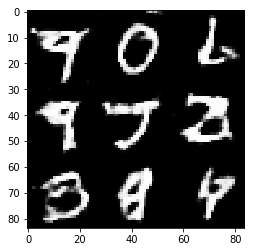

Epoch 2/2... Discriminator Loss: 0.5737... Generator Loss: 2.3660
Epoch 2/2... Discriminator Loss: 0.4931... Generator Loss: 2.6850
Epoch 2/2... Discriminator Loss: 0.4834... Generator Loss: 2.1838
Epoch 2/2... Discriminator Loss: 0.4922... Generator Loss: 2.2050
Epoch 2/2... Discriminator Loss: 0.5394... Generator Loss: 2.7252
Epoch 2/2... Discriminator Loss: 0.5287... Generator Loss: 2.2279
Epoch 2/2... Discriminator Loss: 0.5927... Generator Loss: 1.7016
Epoch 2/2... Discriminator Loss: 0.7199... Generator Loss: 1.5971
Epoch 2/2... Discriminator Loss: 0.6413... Generator Loss: 1.6789
Epoch 2/2... Discriminator Loss: 0.6703... Generator Loss: 2.0496


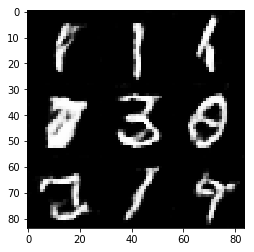

Epoch 2/2... Discriminator Loss: 0.4869... Generator Loss: 2.4635
Epoch 2/2... Discriminator Loss: 0.4866... Generator Loss: 3.0859
Epoch 2/2... Discriminator Loss: 0.6600... Generator Loss: 4.5028
Epoch 2/2... Discriminator Loss: 0.5277... Generator Loss: 3.1301
Epoch 2/2... Discriminator Loss: 0.7618... Generator Loss: 1.8858
Epoch 2/2... Discriminator Loss: 0.5563... Generator Loss: 2.5576
Epoch 2/2... Discriminator Loss: 0.5526... Generator Loss: 2.3263
Epoch 2/2... Discriminator Loss: 0.5984... Generator Loss: 2.0710
Epoch 2/2... Discriminator Loss: 0.6090... Generator Loss: 2.6058
Epoch 2/2... Discriminator Loss: 0.9119... Generator Loss: 1.2930


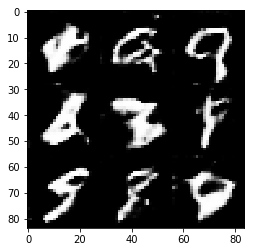

Epoch 2/2... Discriminator Loss: 0.6656... Generator Loss: 1.5840
Epoch 2/2... Discriminator Loss: 0.6567... Generator Loss: 1.7124
Epoch 2/2... Discriminator Loss: 0.7019... Generator Loss: 2.3572
Epoch 2/2... Discriminator Loss: 0.5111... Generator Loss: 2.3579
Epoch 2/2... Discriminator Loss: 0.4574... Generator Loss: 3.1638
Epoch 2/2... Discriminator Loss: 0.6696... Generator Loss: 1.5723
Epoch 2/2... Discriminator Loss: 0.8004... Generator Loss: 1.9101
Epoch 2/2... Discriminator Loss: 1.0649... Generator Loss: 1.4591
Epoch 2/2... Discriminator Loss: 0.6235... Generator Loss: 3.5989
Epoch 2/2... Discriminator Loss: 0.6622... Generator Loss: 2.5448


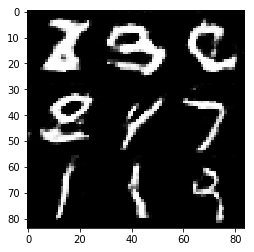

Epoch 2/2... Discriminator Loss: 0.5786... Generator Loss: 2.9539
Epoch 2/2... Discriminator Loss: 0.5805... Generator Loss: 2.1391
Epoch 2/2... Discriminator Loss: 0.5898... Generator Loss: 1.9182
Epoch 2/2... Discriminator Loss: 0.4623... Generator Loss: 3.2608
Epoch 2/2... Discriminator Loss: 0.7183... Generator Loss: 2.1567
Epoch 2/2... Discriminator Loss: 0.7379... Generator Loss: 1.7428
Epoch 2/2... Discriminator Loss: 0.5248... Generator Loss: 2.0011
Epoch 2/2... Discriminator Loss: 0.5500... Generator Loss: 3.3177
Epoch 2/2... Discriminator Loss: 0.6781... Generator Loss: 3.2772
Epoch 2/2... Discriminator Loss: 0.5273... Generator Loss: 2.2810


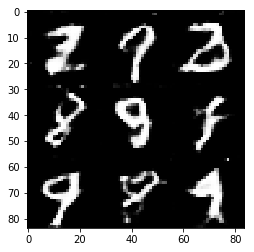

Epoch 2/2... Discriminator Loss: 0.5240... Generator Loss: 2.5797
Epoch 2/2... Discriminator Loss: 0.4410... Generator Loss: 2.8904
Epoch 2/2... Discriminator Loss: 1.2229... Generator Loss: 4.7932
Epoch 2/2... Discriminator Loss: 0.5305... Generator Loss: 2.4512
Epoch 2/2... Discriminator Loss: 0.5741... Generator Loss: 3.0801
Epoch 2/2... Discriminator Loss: 0.7109... Generator Loss: 2.0074
Epoch 2/2... Discriminator Loss: 0.4463... Generator Loss: 3.0783
Epoch 2/2... Discriminator Loss: 0.4671... Generator Loss: 2.8655
Epoch 2/2... Discriminator Loss: 0.5649... Generator Loss: 1.8395
Epoch 2/2... Discriminator Loss: 0.4609... Generator Loss: 2.9440


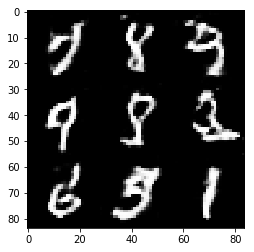

Epoch 2/2... Discriminator Loss: 0.6886... Generator Loss: 3.5302
Epoch 2/2... Discriminator Loss: 0.4963... Generator Loss: 2.9032
Epoch 2/2... Discriminator Loss: 0.5493... Generator Loss: 2.4064
Epoch 2/2... Discriminator Loss: 0.6777... Generator Loss: 2.5569
Epoch 2/2... Discriminator Loss: 0.5400... Generator Loss: 3.3594
Epoch 2/2... Discriminator Loss: 0.5380... Generator Loss: 2.4038
Epoch 2/2... Discriminator Loss: 0.4362... Generator Loss: 3.8652
Epoch 2/2... Discriminator Loss: 0.9270... Generator Loss: 1.3159
Epoch 2/2... Discriminator Loss: 0.6602... Generator Loss: 1.9906
Epoch 2/2... Discriminator Loss: 0.5274... Generator Loss: 2.2740


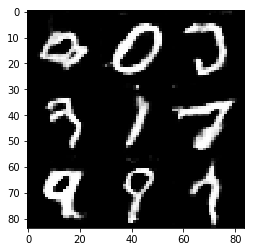

Epoch 2/2... Discriminator Loss: 0.8182... Generator Loss: 1.2261
Epoch 2/2... Discriminator Loss: 0.5049... Generator Loss: 2.9107
Epoch 2/2... Discriminator Loss: 0.5218... Generator Loss: 2.3055
Epoch 2/2... Discriminator Loss: 0.4880... Generator Loss: 2.2177
Epoch 2/2... Discriminator Loss: 0.5376... Generator Loss: 2.4037
Epoch 2/2... Discriminator Loss: 0.4536... Generator Loss: 2.5337
Epoch 2/2... Discriminator Loss: 0.4681... Generator Loss: 3.3497
Epoch 2/2... Discriminator Loss: 0.5680... Generator Loss: 2.6938
Epoch 2/2... Discriminator Loss: 0.5482... Generator Loss: 2.6735
Epoch 2/2... Discriminator Loss: 0.5289... Generator Loss: 2.7738


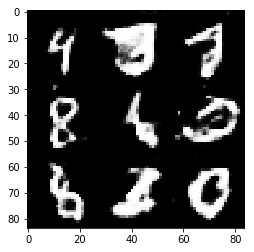

Epoch 2/2... Discriminator Loss: 0.7476... Generator Loss: 1.5896
Epoch 2/2... Discriminator Loss: 0.5453... Generator Loss: 2.8791
Epoch 2/2... Discriminator Loss: 0.5942... Generator Loss: 2.2405
Epoch 2/2... Discriminator Loss: 0.4783... Generator Loss: 3.0731
Epoch 2/2... Discriminator Loss: 0.6137... Generator Loss: 1.7878
Epoch 2/2... Discriminator Loss: 0.5342... Generator Loss: 2.8803
Epoch 2/2... Discriminator Loss: 0.5143... Generator Loss: 2.6508
Epoch 2/2... Discriminator Loss: 0.9575... Generator Loss: 3.6357
Epoch 2/2... Discriminator Loss: 0.5175... Generator Loss: 2.7565
Epoch 2/2... Discriminator Loss: 0.5116... Generator Loss: 3.1132


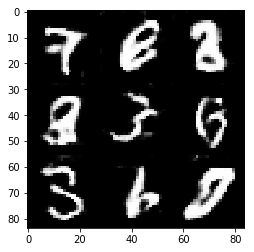

Epoch 2/2... Discriminator Loss: 0.5251... Generator Loss: 3.0209
Epoch 2/2... Discriminator Loss: 0.5665... Generator Loss: 2.8103
Epoch 2/2... Discriminator Loss: 0.5112... Generator Loss: 2.2136
Epoch 2/2... Discriminator Loss: 0.4961... Generator Loss: 3.1753
Epoch 2/2... Discriminator Loss: 0.7357... Generator Loss: 4.4768
Epoch 2/2... Discriminator Loss: 1.0959... Generator Loss: 3.7605
Epoch 2/2... Discriminator Loss: 0.4624... Generator Loss: 2.4775
Epoch 2/2... Discriminator Loss: 0.5142... Generator Loss: 2.6564
Epoch 2/2... Discriminator Loss: 0.5147... Generator Loss: 2.8615
Epoch 2/2... Discriminator Loss: 0.5086... Generator Loss: 2.4563


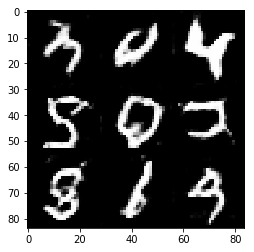

Epoch 2/2... Discriminator Loss: 0.5134... Generator Loss: 2.4872
Epoch 2/2... Discriminator Loss: 0.4440... Generator Loss: 3.5453
Epoch 2/2... Discriminator Loss: 0.7822... Generator Loss: 4.6100
Epoch 2/2... Discriminator Loss: 0.6192... Generator Loss: 3.4093
Epoch 2/2... Discriminator Loss: 0.7702... Generator Loss: 4.2108
Epoch 2/2... Discriminator Loss: 0.5935... Generator Loss: 2.2006
Epoch 2/2... Discriminator Loss: 0.5705... Generator Loss: 2.6321
Epoch 2/2... Discriminator Loss: 0.4988... Generator Loss: 3.3329
Epoch 2/2... Discriminator Loss: 0.5262... Generator Loss: 2.7319
Epoch 2/2... Discriminator Loss: 0.4328... Generator Loss: 3.0248


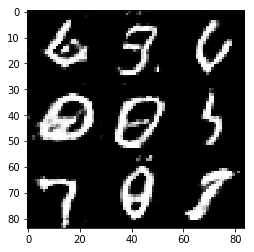

Epoch 2/2... Discriminator Loss: 0.4482... Generator Loss: 2.8714
Epoch 2/2... Discriminator Loss: 0.5261... Generator Loss: 4.0128
Epoch 2/2... Discriminator Loss: 0.6378... Generator Loss: 1.9586
Epoch 2/2... Discriminator Loss: 0.5619... Generator Loss: 2.8068
Epoch 2/2... Discriminator Loss: 0.5047... Generator Loss: 2.6954
Epoch 2/2... Discriminator Loss: 0.5456... Generator Loss: 2.7005
Epoch 2/2... Discriminator Loss: 0.5575... Generator Loss: 3.2325
Epoch 2/2... Discriminator Loss: 0.5098... Generator Loss: 3.1647
Epoch 2/2... Discriminator Loss: 0.5408... Generator Loss: 2.3581
Epoch 2/2... Discriminator Loss: 0.4671... Generator Loss: 2.8627


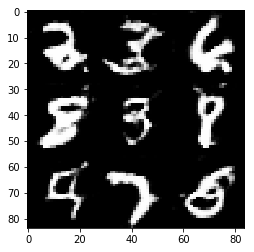

Epoch 2/2... Discriminator Loss: 0.4548... Generator Loss: 2.1720
Epoch 2/2... Discriminator Loss: 0.8586... Generator Loss: 1.7207
Epoch 2/2... Discriminator Loss: 0.6210... Generator Loss: 1.8011
Epoch 2/2... Discriminator Loss: 0.7189... Generator Loss: 2.1947
Epoch 2/2... Discriminator Loss: 0.4968... Generator Loss: 2.9975
Epoch 2/2... Discriminator Loss: 0.5058... Generator Loss: 2.6799
Epoch 2/2... Discriminator Loss: 0.6574... Generator Loss: 1.4998
Epoch 2/2... Discriminator Loss: 0.4661... Generator Loss: 2.6253
Epoch 2/2... Discriminator Loss: 0.5007... Generator Loss: 2.5936
Epoch 2/2... Discriminator Loss: 0.4410... Generator Loss: 3.8737


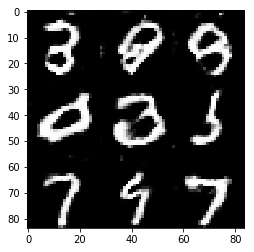

Epoch 2/2... Discriminator Loss: 0.5012... Generator Loss: 2.7484
Epoch 2/2... Discriminator Loss: 0.6169... Generator Loss: 2.7480
Epoch 2/2... Discriminator Loss: 0.4508... Generator Loss: 3.8227
Epoch 2/2... Discriminator Loss: 0.5055... Generator Loss: 3.0896
Epoch 2/2... Discriminator Loss: 0.6699... Generator Loss: 2.4162
Epoch 2/2... Discriminator Loss: 0.4499... Generator Loss: 3.4006
Epoch 2/2... Discriminator Loss: 0.4877... Generator Loss: 2.7297
Epoch 2/2... Discriminator Loss: 0.4541... Generator Loss: 4.1750
Epoch 2/2... Discriminator Loss: 0.4488... Generator Loss: 3.7724
Epoch 2/2... Discriminator Loss: 0.4296... Generator Loss: 3.0950


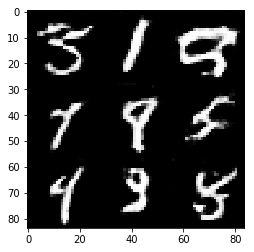

Epoch 2/2... Discriminator Loss: 1.0082... Generator Loss: 4.0065
Epoch 2/2... Discriminator Loss: 0.5316... Generator Loss: 2.7422
Epoch 2/2... Discriminator Loss: 0.5491... Generator Loss: 2.1709
Epoch 2/2... Discriminator Loss: 0.5127... Generator Loss: 2.6823
Epoch 2/2... Discriminator Loss: 0.4252... Generator Loss: 3.1473
Epoch 2/2... Discriminator Loss: 0.5271... Generator Loss: 2.8888
Epoch 2/2... Discriminator Loss: 0.4363... Generator Loss: 3.4778
Epoch 2/2... Discriminator Loss: 0.4557... Generator Loss: 3.8016
Epoch 2/2... Discriminator Loss: 0.4662... Generator Loss: 2.8197
Epoch 2/2... Discriminator Loss: 0.5840... Generator Loss: 2.1033


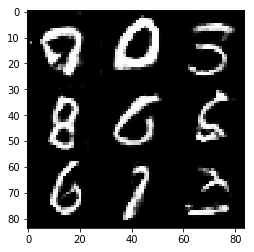

Epoch 2/2... Discriminator Loss: 0.5016... Generator Loss: 2.6844
Epoch 2/2... Discriminator Loss: 0.4598... Generator Loss: 4.1139
Epoch 2/2... Discriminator Loss: 0.5027... Generator Loss: 3.2948
Epoch 2/2... Discriminator Loss: 0.5104... Generator Loss: 2.8665
Epoch 2/2... Discriminator Loss: 0.4227... Generator Loss: 3.0098
Epoch 2/2... Discriminator Loss: 3.1904... Generator Loss: 0.2270
Epoch 2/2... Discriminator Loss: 0.8064... Generator Loss: 1.6963
Epoch 2/2... Discriminator Loss: 0.5962... Generator Loss: 1.8962
Epoch 2/2... Discriminator Loss: 0.5673... Generator Loss: 3.0203
Epoch 2/2... Discriminator Loss: 0.4323... Generator Loss: 3.7947


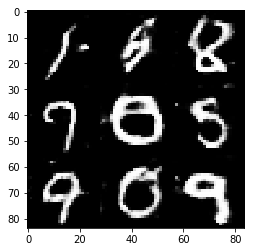

Epoch 2/2... Discriminator Loss: 0.5155... Generator Loss: 3.2680
Epoch 2/2... Discriminator Loss: 0.4538... Generator Loss: 2.9440
Epoch 2/2... Discriminator Loss: 0.4440... Generator Loss: 3.4024
Epoch 2/2... Discriminator Loss: 0.4618... Generator Loss: 2.8645
Epoch 2/2... Discriminator Loss: 0.6306... Generator Loss: 2.6673
Epoch 2/2... Discriminator Loss: 0.6547... Generator Loss: 4.3378
Epoch 2/2... Discriminator Loss: 0.7369... Generator Loss: 1.8355
Epoch 2/2... Discriminator Loss: 0.5530... Generator Loss: 2.5110
Epoch 2/2... Discriminator Loss: 0.5635... Generator Loss: 4.3665
Epoch 2/2... Discriminator Loss: 0.5281... Generator Loss: 3.0668


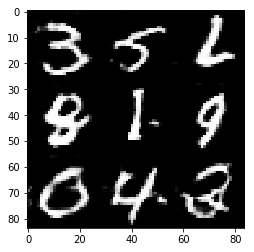

Epoch 2/2... Discriminator Loss: 0.4981... Generator Loss: 3.1129
Epoch 2/2... Discriminator Loss: 0.5179... Generator Loss: 4.2545
Epoch 2/2... Discriminator Loss: 0.9911... Generator Loss: 1.3660
Epoch 2/2... Discriminator Loss: 0.7983... Generator Loss: 1.9639
Epoch 2/2... Discriminator Loss: 0.4743... Generator Loss: 2.9110
Epoch 2/2... Discriminator Loss: 0.5358... Generator Loss: 2.9936
Epoch 2/2... Discriminator Loss: 0.4211... Generator Loss: 3.5249
Epoch 2/2... Discriminator Loss: 0.5722... Generator Loss: 3.0041
Epoch 2/2... Discriminator Loss: 0.4224... Generator Loss: 4.3298
Epoch 2/2... Discriminator Loss: 0.4260... Generator Loss: 3.2547


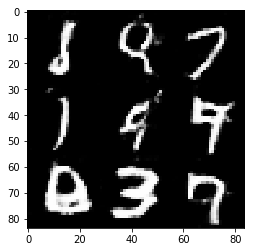

Epoch 2/2... Discriminator Loss: 0.4114... Generator Loss: 4.2699
Epoch 2/2... Discriminator Loss: 0.4171... Generator Loss: 4.2487
Epoch 2/2... Discriminator Loss: 0.5141... Generator Loss: 2.7883
Epoch 2/2... Discriminator Loss: 0.4808... Generator Loss: 2.7694
Epoch 2/2... Discriminator Loss: 0.4951... Generator Loss: 3.3862
Epoch 2/2... Discriminator Loss: 0.4091... Generator Loss: 3.6790
Epoch 2/2... Discriminator Loss: 0.4478... Generator Loss: 3.4707
Epoch 2/2... Discriminator Loss: 0.4285... Generator Loss: 3.5217
Epoch 2/2... Discriminator Loss: 0.4237... Generator Loss: 4.1722
Epoch 2/2... Discriminator Loss: 0.7812... Generator Loss: 4.4223


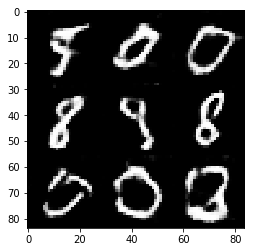

Epoch 2/2... Discriminator Loss: 0.4499... Generator Loss: 3.8949
Epoch 2/2... Discriminator Loss: 0.7035... Generator Loss: 1.8962
Epoch 2/2... Discriminator Loss: 0.8591... Generator Loss: 1.7271
Epoch 2/2... Discriminator Loss: 0.6005... Generator Loss: 4.2261
Epoch 2/2... Discriminator Loss: 0.4832... Generator Loss: 4.2239


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4461... Generator Loss: 3.1857
Epoch 1/1... Discriminator Loss: 0.4071... Generator Loss: 4.1398
Epoch 1/1... Discriminator Loss: 0.3689... Generator Loss: 4.0355
Epoch 1/1... Discriminator Loss: 0.3821... Generator Loss: 4.5212
Epoch 1/1... Discriminator Loss: 0.3584... Generator Loss: 5.2012
Epoch 1/1... Discriminator Loss: 0.4199... Generator Loss: 4.3370
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 2.0409
Epoch 1/1... Discriminator Loss: 0.5541... Generator Loss: 2.9020
Epoch 1/1... Discriminator Loss: 0.8022... Generator Loss: 1.8030
Epoch 1/1... Discriminator Loss: 0.4491... Generator Loss: 3.7546


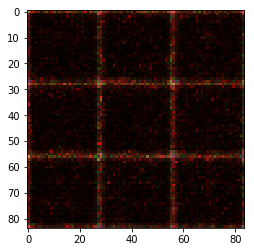

Epoch 1/1... Discriminator Loss: 0.4097... Generator Loss: 4.5047
Epoch 1/1... Discriminator Loss: 0.4755... Generator Loss: 4.5376
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.8430
Epoch 1/1... Discriminator Loss: 0.4091... Generator Loss: 4.3438
Epoch 1/1... Discriminator Loss: 0.3872... Generator Loss: 4.5004
Epoch 1/1... Discriminator Loss: 0.3717... Generator Loss: 4.9045
Epoch 1/1... Discriminator Loss: 0.3630... Generator Loss: 4.8542
Epoch 1/1... Discriminator Loss: 0.3726... Generator Loss: 4.5158
Epoch 1/1... Discriminator Loss: 0.5215... Generator Loss: 2.6889
Epoch 1/1... Discriminator Loss: 0.3529... Generator Loss: 5.2962


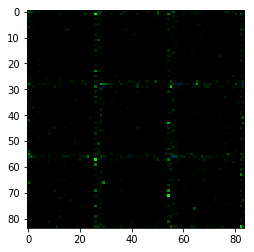

Epoch 1/1... Discriminator Loss: 0.3766... Generator Loss: 4.4455
Epoch 1/1... Discriminator Loss: 0.3837... Generator Loss: 7.0170
Epoch 1/1... Discriminator Loss: 0.3714... Generator Loss: 5.4440
Epoch 1/1... Discriminator Loss: 0.3507... Generator Loss: 6.7172
Epoch 1/1... Discriminator Loss: 0.3717... Generator Loss: 4.1677
Epoch 1/1... Discriminator Loss: 0.3551... Generator Loss: 5.4133
Epoch 1/1... Discriminator Loss: 0.5388... Generator Loss: 6.1472
Epoch 1/1... Discriminator Loss: 0.3971... Generator Loss: 4.9772
Epoch 1/1... Discriminator Loss: 0.3811... Generator Loss: 4.6590
Epoch 1/1... Discriminator Loss: 0.4110... Generator Loss: 3.2721


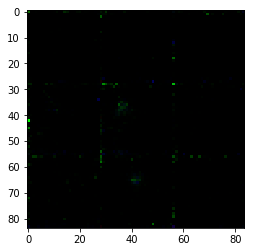

Epoch 1/1... Discriminator Loss: 0.3745... Generator Loss: 4.7425
Epoch 1/1... Discriminator Loss: 0.3659... Generator Loss: 5.0925
Epoch 1/1... Discriminator Loss: 0.5843... Generator Loss: 2.1674
Epoch 1/1... Discriminator Loss: 0.4201... Generator Loss: 3.8446
Epoch 1/1... Discriminator Loss: 0.3810... Generator Loss: 3.8816
Epoch 1/1... Discriminator Loss: 0.5364... Generator Loss: 2.1560
Epoch 1/1... Discriminator Loss: 0.3750... Generator Loss: 4.3936
Epoch 1/1... Discriminator Loss: 0.4345... Generator Loss: 3.6914
Epoch 1/1... Discriminator Loss: 0.4144... Generator Loss: 3.8483
Epoch 1/1... Discriminator Loss: 0.5160... Generator Loss: 4.3713


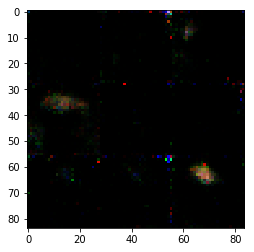

Epoch 1/1... Discriminator Loss: 0.8081... Generator Loss: 1.3430
Epoch 1/1... Discriminator Loss: 0.5190... Generator Loss: 2.5575
Epoch 1/1... Discriminator Loss: 0.7757... Generator Loss: 1.9654
Epoch 1/1... Discriminator Loss: 0.4522... Generator Loss: 2.9351
Epoch 1/1... Discriminator Loss: 0.4278... Generator Loss: 3.2225
Epoch 1/1... Discriminator Loss: 1.8670... Generator Loss: 4.7936
Epoch 1/1... Discriminator Loss: 0.4914... Generator Loss: 3.9542
Epoch 1/1... Discriminator Loss: 0.5082... Generator Loss: 2.7415
Epoch 1/1... Discriminator Loss: 0.4489... Generator Loss: 2.9953
Epoch 1/1... Discriminator Loss: 0.5033... Generator Loss: 3.0835


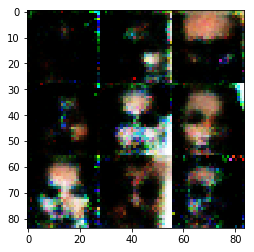

Epoch 1/1... Discriminator Loss: 0.5755... Generator Loss: 2.0496
Epoch 1/1... Discriminator Loss: 0.4422... Generator Loss: 3.5697
Epoch 1/1... Discriminator Loss: 0.4159... Generator Loss: 3.4504
Epoch 1/1... Discriminator Loss: 0.8219... Generator Loss: 1.3910
Epoch 1/1... Discriminator Loss: 0.5172... Generator Loss: 2.5583
Epoch 1/1... Discriminator Loss: 0.4139... Generator Loss: 3.1685
Epoch 1/1... Discriminator Loss: 0.4994... Generator Loss: 4.0079
Epoch 1/1... Discriminator Loss: 0.4946... Generator Loss: 3.6993
Epoch 1/1... Discriminator Loss: 0.4304... Generator Loss: 3.4290
Epoch 1/1... Discriminator Loss: 0.7266... Generator Loss: 1.6805


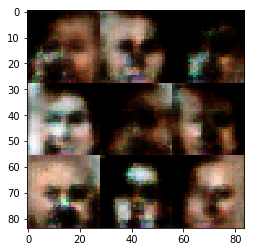

Epoch 1/1... Discriminator Loss: 0.4573... Generator Loss: 6.1091
Epoch 1/1... Discriminator Loss: 0.4173... Generator Loss: 4.1538
Epoch 1/1... Discriminator Loss: 0.4329... Generator Loss: 3.1487
Epoch 1/1... Discriminator Loss: 0.6440... Generator Loss: 1.5651
Epoch 1/1... Discriminator Loss: 0.5090... Generator Loss: 2.1179
Epoch 1/1... Discriminator Loss: 0.5775... Generator Loss: 2.4902
Epoch 1/1... Discriminator Loss: 0.5077... Generator Loss: 2.7039
Epoch 1/1... Discriminator Loss: 0.6463... Generator Loss: 4.1298
Epoch 1/1... Discriminator Loss: 0.4876... Generator Loss: 2.6521
Epoch 1/1... Discriminator Loss: 0.6529... Generator Loss: 1.6673


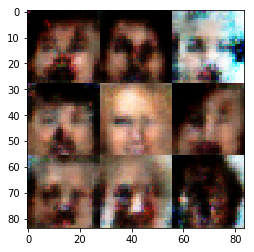

Epoch 1/1... Discriminator Loss: 0.5039... Generator Loss: 4.3669
Epoch 1/1... Discriminator Loss: 0.6001... Generator Loss: 1.8957
Epoch 1/1... Discriminator Loss: 0.7270... Generator Loss: 3.9502
Epoch 1/1... Discriminator Loss: 0.5492... Generator Loss: 3.1324
Epoch 1/1... Discriminator Loss: 0.6338... Generator Loss: 2.1014
Epoch 1/1... Discriminator Loss: 0.6554... Generator Loss: 1.9135
Epoch 1/1... Discriminator Loss: 0.6035... Generator Loss: 2.2345
Epoch 1/1... Discriminator Loss: 0.7521... Generator Loss: 1.3993
Epoch 1/1... Discriminator Loss: 0.9478... Generator Loss: 1.3687
Epoch 1/1... Discriminator Loss: 0.7619... Generator Loss: 1.3566


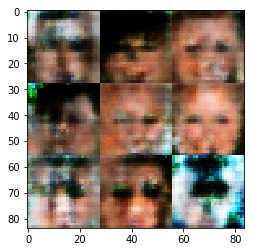

Epoch 1/1... Discriminator Loss: 0.8559... Generator Loss: 4.3524
Epoch 1/1... Discriminator Loss: 0.7175... Generator Loss: 1.5866
Epoch 1/1... Discriminator Loss: 0.7902... Generator Loss: 1.6714
Epoch 1/1... Discriminator Loss: 0.6460... Generator Loss: 2.3191
Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 0.9575
Epoch 1/1... Discriminator Loss: 0.6116... Generator Loss: 2.8106
Epoch 1/1... Discriminator Loss: 0.8514... Generator Loss: 3.5082
Epoch 1/1... Discriminator Loss: 0.6719... Generator Loss: 2.0206
Epoch 1/1... Discriminator Loss: 0.5150... Generator Loss: 2.9290
Epoch 1/1... Discriminator Loss: 0.6254... Generator Loss: 1.7059


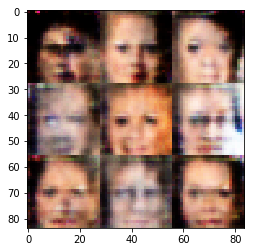

Epoch 1/1... Discriminator Loss: 0.6948... Generator Loss: 2.6351
Epoch 1/1... Discriminator Loss: 1.0971... Generator Loss: 1.0297
Epoch 1/1... Discriminator Loss: 0.6309... Generator Loss: 1.9478
Epoch 1/1... Discriminator Loss: 0.9776... Generator Loss: 2.7662
Epoch 1/1... Discriminator Loss: 0.8864... Generator Loss: 1.5556
Epoch 1/1... Discriminator Loss: 0.6064... Generator Loss: 1.9311
Epoch 1/1... Discriminator Loss: 0.5466... Generator Loss: 2.2211
Epoch 1/1... Discriminator Loss: 0.7902... Generator Loss: 1.6321
Epoch 1/1... Discriminator Loss: 0.6721... Generator Loss: 2.1264
Epoch 1/1... Discriminator Loss: 0.6399... Generator Loss: 1.8996


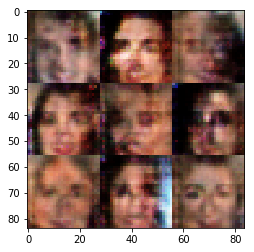

Epoch 1/1... Discriminator Loss: 0.9037... Generator Loss: 1.8781
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 3.8319
Epoch 1/1... Discriminator Loss: 0.7638... Generator Loss: 1.7411
Epoch 1/1... Discriminator Loss: 0.7550... Generator Loss: 2.2877
Epoch 1/1... Discriminator Loss: 0.6881... Generator Loss: 2.2623
Epoch 1/1... Discriminator Loss: 0.9531... Generator Loss: 3.5922
Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 3.3011
Epoch 1/1... Discriminator Loss: 0.6629... Generator Loss: 2.0795
Epoch 1/1... Discriminator Loss: 0.7090... Generator Loss: 2.2048
Epoch 1/1... Discriminator Loss: 0.8628... Generator Loss: 1.2099


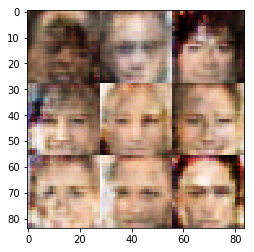

Epoch 1/1... Discriminator Loss: 0.8459... Generator Loss: 1.8522
Epoch 1/1... Discriminator Loss: 0.6287... Generator Loss: 2.1819
Epoch 1/1... Discriminator Loss: 0.6853... Generator Loss: 1.7190
Epoch 1/1... Discriminator Loss: 0.9146... Generator Loss: 2.0654
Epoch 1/1... Discriminator Loss: 0.7945... Generator Loss: 2.2614
Epoch 1/1... Discriminator Loss: 0.8342... Generator Loss: 1.6997
Epoch 1/1... Discriminator Loss: 1.0412... Generator Loss: 2.7153
Epoch 1/1... Discriminator Loss: 0.6610... Generator Loss: 2.1947
Epoch 1/1... Discriminator Loss: 0.8756... Generator Loss: 2.2255
Epoch 1/1... Discriminator Loss: 0.6693... Generator Loss: 1.8609


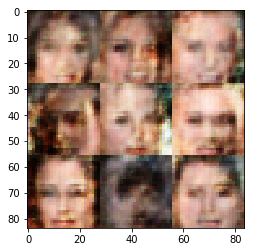

Epoch 1/1... Discriminator Loss: 0.8892... Generator Loss: 1.6288
Epoch 1/1... Discriminator Loss: 0.6883... Generator Loss: 1.7945
Epoch 1/1... Discriminator Loss: 0.7983... Generator Loss: 2.1391
Epoch 1/1... Discriminator Loss: 0.6319... Generator Loss: 2.0742
Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 1.2223
Epoch 1/1... Discriminator Loss: 0.9632... Generator Loss: 1.2087
Epoch 1/1... Discriminator Loss: 1.0440... Generator Loss: 2.6464
Epoch 1/1... Discriminator Loss: 0.8942... Generator Loss: 2.2193
Epoch 1/1... Discriminator Loss: 0.8070... Generator Loss: 1.6316
Epoch 1/1... Discriminator Loss: 0.8821... Generator Loss: 1.3907


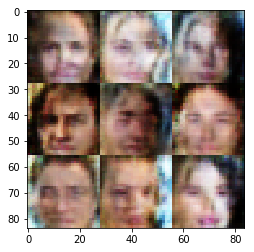

Epoch 1/1... Discriminator Loss: 1.0301... Generator Loss: 0.8430
Epoch 1/1... Discriminator Loss: 0.7640... Generator Loss: 2.2563
Epoch 1/1... Discriminator Loss: 0.7975... Generator Loss: 1.6822
Epoch 1/1... Discriminator Loss: 0.7444... Generator Loss: 1.5324
Epoch 1/1... Discriminator Loss: 0.7268... Generator Loss: 1.6283
Epoch 1/1... Discriminator Loss: 0.7298... Generator Loss: 1.4895
Epoch 1/1... Discriminator Loss: 0.7163... Generator Loss: 1.4973
Epoch 1/1... Discriminator Loss: 0.7265... Generator Loss: 1.5775
Epoch 1/1... Discriminator Loss: 0.8086... Generator Loss: 1.9178
Epoch 1/1... Discriminator Loss: 0.7470... Generator Loss: 1.9143


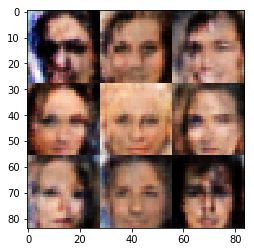

Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 1.0965
Epoch 1/1... Discriminator Loss: 0.8719... Generator Loss: 2.1473
Epoch 1/1... Discriminator Loss: 0.8698... Generator Loss: 1.3044
Epoch 1/1... Discriminator Loss: 0.6952... Generator Loss: 1.8645
Epoch 1/1... Discriminator Loss: 0.8034... Generator Loss: 1.2138
Epoch 1/1... Discriminator Loss: 0.9393... Generator Loss: 1.4243
Epoch 1/1... Discriminator Loss: 0.7239... Generator Loss: 2.0371
Epoch 1/1... Discriminator Loss: 0.7446... Generator Loss: 1.4595
Epoch 1/1... Discriminator Loss: 0.8726... Generator Loss: 2.2988
Epoch 1/1... Discriminator Loss: 0.7555... Generator Loss: 1.9116


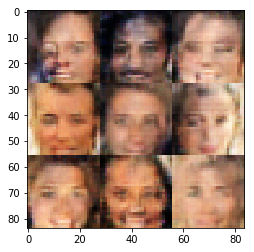

Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 1.0153
Epoch 1/1... Discriminator Loss: 0.7847... Generator Loss: 1.6350
Epoch 1/1... Discriminator Loss: 0.7534... Generator Loss: 1.6382
Epoch 1/1... Discriminator Loss: 0.9358... Generator Loss: 1.2189
Epoch 1/1... Discriminator Loss: 0.9939... Generator Loss: 1.2093
Epoch 1/1... Discriminator Loss: 0.8529... Generator Loss: 1.5980
Epoch 1/1... Discriminator Loss: 0.8885... Generator Loss: 1.2970
Epoch 1/1... Discriminator Loss: 0.7553... Generator Loss: 1.2676
Epoch 1/1... Discriminator Loss: 0.9929... Generator Loss: 1.0486
Epoch 1/1... Discriminator Loss: 0.8172... Generator Loss: 1.3085


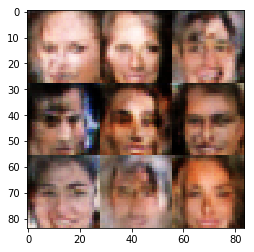

Epoch 1/1... Discriminator Loss: 0.8468... Generator Loss: 1.1153
Epoch 1/1... Discriminator Loss: 0.9549... Generator Loss: 1.4367
Epoch 1/1... Discriminator Loss: 0.7660... Generator Loss: 1.4755
Epoch 1/1... Discriminator Loss: 0.8378... Generator Loss: 1.5492
Epoch 1/1... Discriminator Loss: 0.8161... Generator Loss: 1.3906
Epoch 1/1... Discriminator Loss: 0.7990... Generator Loss: 2.0644
Epoch 1/1... Discriminator Loss: 0.7623... Generator Loss: 1.6366
Epoch 1/1... Discriminator Loss: 0.8602... Generator Loss: 1.4881
Epoch 1/1... Discriminator Loss: 0.9020... Generator Loss: 1.7102
Epoch 1/1... Discriminator Loss: 0.8823... Generator Loss: 1.4784


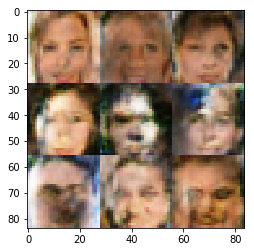

Epoch 1/1... Discriminator Loss: 0.8471... Generator Loss: 1.6222
Epoch 1/1... Discriminator Loss: 0.9803... Generator Loss: 0.9856
Epoch 1/1... Discriminator Loss: 0.6543... Generator Loss: 2.5419
Epoch 1/1... Discriminator Loss: 0.8934... Generator Loss: 1.4604
Epoch 1/1... Discriminator Loss: 0.7307... Generator Loss: 1.8270
Epoch 1/1... Discriminator Loss: 0.7481... Generator Loss: 1.9056
Epoch 1/1... Discriminator Loss: 0.8294... Generator Loss: 1.1490
Epoch 1/1... Discriminator Loss: 0.8637... Generator Loss: 1.3353
Epoch 1/1... Discriminator Loss: 0.7803... Generator Loss: 1.7227
Epoch 1/1... Discriminator Loss: 0.9131... Generator Loss: 0.9511


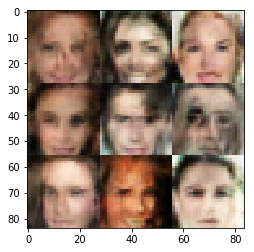

Epoch 1/1... Discriminator Loss: 0.9147... Generator Loss: 1.0958
Epoch 1/1... Discriminator Loss: 0.9062... Generator Loss: 2.1575
Epoch 1/1... Discriminator Loss: 0.8420... Generator Loss: 1.4064
Epoch 1/1... Discriminator Loss: 0.7547... Generator Loss: 1.6536
Epoch 1/1... Discriminator Loss: 1.0836... Generator Loss: 0.9311
Epoch 1/1... Discriminator Loss: 0.9187... Generator Loss: 1.2832
Epoch 1/1... Discriminator Loss: 0.8112... Generator Loss: 1.3830
Epoch 1/1... Discriminator Loss: 0.9360... Generator Loss: 1.0747
Epoch 1/1... Discriminator Loss: 0.6594... Generator Loss: 1.5844
Epoch 1/1... Discriminator Loss: 0.8731... Generator Loss: 1.1844


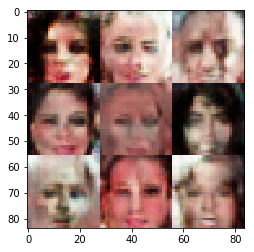

Epoch 1/1... Discriminator Loss: 0.7327... Generator Loss: 1.3481
Epoch 1/1... Discriminator Loss: 0.7152... Generator Loss: 1.8578
Epoch 1/1... Discriminator Loss: 0.8238... Generator Loss: 1.8522
Epoch 1/1... Discriminator Loss: 1.0699... Generator Loss: 0.9679
Epoch 1/1... Discriminator Loss: 1.0812... Generator Loss: 0.8994
Epoch 1/1... Discriminator Loss: 0.8376... Generator Loss: 1.8257
Epoch 1/1... Discriminator Loss: 0.5700... Generator Loss: 2.5346
Epoch 1/1... Discriminator Loss: 0.8142... Generator Loss: 1.2717
Epoch 1/1... Discriminator Loss: 0.7957... Generator Loss: 1.6418
Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 1.4365


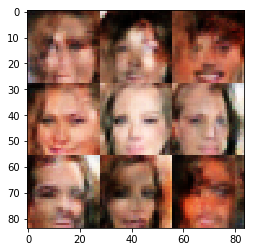

Epoch 1/1... Discriminator Loss: 0.7548... Generator Loss: 1.9004
Epoch 1/1... Discriminator Loss: 0.8257... Generator Loss: 1.5954
Epoch 1/1... Discriminator Loss: 0.9522... Generator Loss: 1.1347
Epoch 1/1... Discriminator Loss: 0.7644... Generator Loss: 1.3716
Epoch 1/1... Discriminator Loss: 0.9031... Generator Loss: 1.9034
Epoch 1/1... Discriminator Loss: 0.8508... Generator Loss: 1.2335
Epoch 1/1... Discriminator Loss: 0.7373... Generator Loss: 1.6928
Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 1.5665
Epoch 1/1... Discriminator Loss: 1.0146... Generator Loss: 1.0320
Epoch 1/1... Discriminator Loss: 0.7263... Generator Loss: 1.7266


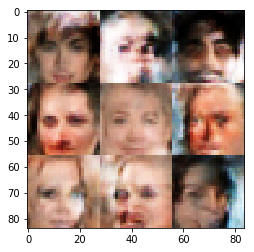

Epoch 1/1... Discriminator Loss: 0.8256... Generator Loss: 1.8450
Epoch 1/1... Discriminator Loss: 1.0011... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 0.7782... Generator Loss: 1.8379
Epoch 1/1... Discriminator Loss: 0.6727... Generator Loss: 1.8507
Epoch 1/1... Discriminator Loss: 0.7585... Generator Loss: 1.7173
Epoch 1/1... Discriminator Loss: 0.7468... Generator Loss: 1.6714
Epoch 1/1... Discriminator Loss: 0.8021... Generator Loss: 1.2089
Epoch 1/1... Discriminator Loss: 0.8615... Generator Loss: 1.2156
Epoch 1/1... Discriminator Loss: 0.8371... Generator Loss: 1.6442
Epoch 1/1... Discriminator Loss: 0.8464... Generator Loss: 1.4190


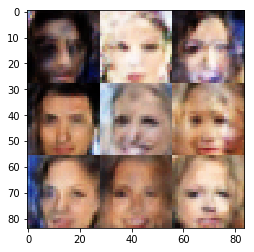

Epoch 1/1... Discriminator Loss: 0.9041... Generator Loss: 1.5006
Epoch 1/1... Discriminator Loss: 0.9391... Generator Loss: 1.1205
Epoch 1/1... Discriminator Loss: 0.8380... Generator Loss: 1.4795
Epoch 1/1... Discriminator Loss: 0.6713... Generator Loss: 2.3685
Epoch 1/1... Discriminator Loss: 0.8333... Generator Loss: 1.1744
Epoch 1/1... Discriminator Loss: 0.8503... Generator Loss: 1.3472
Epoch 1/1... Discriminator Loss: 0.8614... Generator Loss: 1.3856
Epoch 1/1... Discriminator Loss: 0.7935... Generator Loss: 1.1892
Epoch 1/1... Discriminator Loss: 0.7011... Generator Loss: 1.8604
Epoch 1/1... Discriminator Loss: 0.8699... Generator Loss: 1.4514


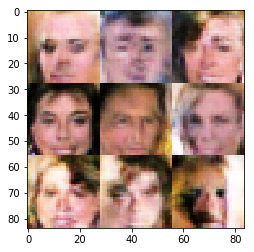

Epoch 1/1... Discriminator Loss: 0.6715... Generator Loss: 2.0248
Epoch 1/1... Discriminator Loss: 0.8928... Generator Loss: 1.2852
Epoch 1/1... Discriminator Loss: 0.8581... Generator Loss: 1.2912
Epoch 1/1... Discriminator Loss: 0.9125... Generator Loss: 1.2803
Epoch 1/1... Discriminator Loss: 1.0105... Generator Loss: 1.0381
Epoch 1/1... Discriminator Loss: 0.7951... Generator Loss: 1.4592
Epoch 1/1... Discriminator Loss: 0.7149... Generator Loss: 1.9815
Epoch 1/1... Discriminator Loss: 0.8402... Generator Loss: 1.7010
Epoch 1/1... Discriminator Loss: 0.7958... Generator Loss: 2.4458
Epoch 1/1... Discriminator Loss: 0.8302... Generator Loss: 1.6296


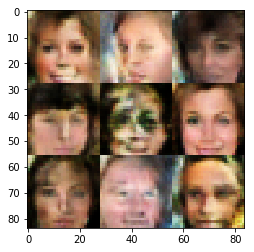

Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 0.7693... Generator Loss: 1.6450
Epoch 1/1... Discriminator Loss: 0.9383... Generator Loss: 1.1741
Epoch 1/1... Discriminator Loss: 0.7356... Generator Loss: 1.3222
Epoch 1/1... Discriminator Loss: 0.7665... Generator Loss: 1.8948
Epoch 1/1... Discriminator Loss: 0.7590... Generator Loss: 1.4804
Epoch 1/1... Discriminator Loss: 0.7723... Generator Loss: 1.8233
Epoch 1/1... Discriminator Loss: 0.7946... Generator Loss: 2.0801
Epoch 1/1... Discriminator Loss: 1.0027... Generator Loss: 1.2983
Epoch 1/1... Discriminator Loss: 0.8940... Generator Loss: 1.2967


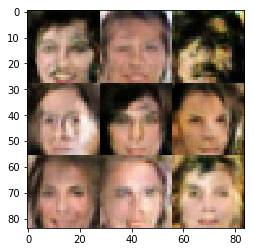

Epoch 1/1... Discriminator Loss: 0.7124... Generator Loss: 2.1626
Epoch 1/1... Discriminator Loss: 0.7347... Generator Loss: 2.4634
Epoch 1/1... Discriminator Loss: 0.8157... Generator Loss: 2.1124
Epoch 1/1... Discriminator Loss: 0.7861... Generator Loss: 1.5968
Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 1.0769
Epoch 1/1... Discriminator Loss: 0.6770... Generator Loss: 2.0128
Epoch 1/1... Discriminator Loss: 0.8351... Generator Loss: 2.2409
Epoch 1/1... Discriminator Loss: 0.9120... Generator Loss: 1.4967
Epoch 1/1... Discriminator Loss: 0.8231... Generator Loss: 1.4377
Epoch 1/1... Discriminator Loss: 0.7699... Generator Loss: 1.3319


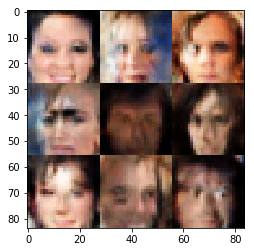

Epoch 1/1... Discriminator Loss: 0.7728... Generator Loss: 1.6851
Epoch 1/1... Discriminator Loss: 0.8290... Generator Loss: 1.5327
Epoch 1/1... Discriminator Loss: 0.8921... Generator Loss: 1.4798
Epoch 1/1... Discriminator Loss: 0.9369... Generator Loss: 1.1996
Epoch 1/1... Discriminator Loss: 1.0393... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 0.7348... Generator Loss: 1.6082
Epoch 1/1... Discriminator Loss: 0.8935... Generator Loss: 1.4499
Epoch 1/1... Discriminator Loss: 0.8800... Generator Loss: 1.4924
Epoch 1/1... Discriminator Loss: 0.6710... Generator Loss: 2.3066
Epoch 1/1... Discriminator Loss: 0.8884... Generator Loss: 2.1191


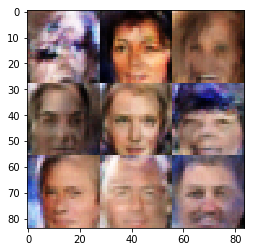

Epoch 1/1... Discriminator Loss: 0.8191... Generator Loss: 1.1572
Epoch 1/1... Discriminator Loss: 0.7634... Generator Loss: 1.4976
Epoch 1/1... Discriminator Loss: 0.9311... Generator Loss: 2.8430
Epoch 1/1... Discriminator Loss: 0.7739... Generator Loss: 2.5630
Epoch 1/1... Discriminator Loss: 0.9632... Generator Loss: 2.4809
Epoch 1/1... Discriminator Loss: 0.6199... Generator Loss: 1.8182
Epoch 1/1... Discriminator Loss: 0.8198... Generator Loss: 1.8303
Epoch 1/1... Discriminator Loss: 1.1431... Generator Loss: 2.6385
Epoch 1/1... Discriminator Loss: 0.8355... Generator Loss: 1.8925
Epoch 1/1... Discriminator Loss: 0.9159... Generator Loss: 1.7758


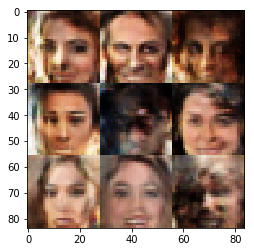

Epoch 1/1... Discriminator Loss: 1.0100... Generator Loss: 1.1252
Epoch 1/1... Discriminator Loss: 0.6587... Generator Loss: 2.1971
Epoch 1/1... Discriminator Loss: 0.8974... Generator Loss: 1.1590
Epoch 1/1... Discriminator Loss: 0.8291... Generator Loss: 1.1383
Epoch 1/1... Discriminator Loss: 0.8184... Generator Loss: 1.5580
Epoch 1/1... Discriminator Loss: 1.0201... Generator Loss: 1.0736
Epoch 1/1... Discriminator Loss: 0.6742... Generator Loss: 1.8990
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 0.7711... Generator Loss: 1.8985
Epoch 1/1... Discriminator Loss: 0.7871... Generator Loss: 1.5153


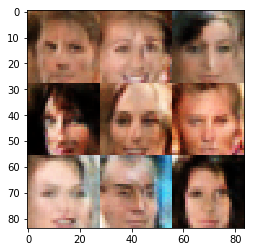

Epoch 1/1... Discriminator Loss: 0.7292... Generator Loss: 2.0509
Epoch 1/1... Discriminator Loss: 0.9303... Generator Loss: 1.2550
Epoch 1/1... Discriminator Loss: 0.8461... Generator Loss: 1.9205
Epoch 1/1... Discriminator Loss: 0.8471... Generator Loss: 2.3349
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.9719
Epoch 1/1... Discriminator Loss: 0.8814... Generator Loss: 1.3166
Epoch 1/1... Discriminator Loss: 0.7375... Generator Loss: 1.6806
Epoch 1/1... Discriminator Loss: 0.5386... Generator Loss: 2.4721
Epoch 1/1... Discriminator Loss: 1.0101... Generator Loss: 1.4453
Epoch 1/1... Discriminator Loss: 0.8013... Generator Loss: 1.4367


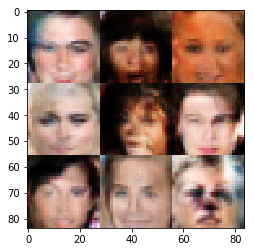

Epoch 1/1... Discriminator Loss: 0.7541... Generator Loss: 1.5973
Epoch 1/1... Discriminator Loss: 0.7769... Generator Loss: 2.3626
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 0.7101... Generator Loss: 1.9631
Epoch 1/1... Discriminator Loss: 0.8292... Generator Loss: 1.3886
Epoch 1/1... Discriminator Loss: 0.8465... Generator Loss: 1.8835
Epoch 1/1... Discriminator Loss: 0.8667... Generator Loss: 1.2812
Epoch 1/1... Discriminator Loss: 0.7421... Generator Loss: 1.4776
Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 1.4464
Epoch 1/1... Discriminator Loss: 0.9579... Generator Loss: 0.6910


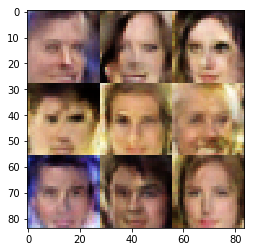

Epoch 1/1... Discriminator Loss: 0.7869... Generator Loss: 1.5427
Epoch 1/1... Discriminator Loss: 0.8824... Generator Loss: 2.2624
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 2.3791
Epoch 1/1... Discriminator Loss: 0.9623... Generator Loss: 1.3608
Epoch 1/1... Discriminator Loss: 0.8112... Generator Loss: 2.1619
Epoch 1/1... Discriminator Loss: 0.8858... Generator Loss: 2.3511
Epoch 1/1... Discriminator Loss: 0.8804... Generator Loss: 1.6648
Epoch 1/1... Discriminator Loss: 0.7168... Generator Loss: 1.5273
Epoch 1/1... Discriminator Loss: 0.8436... Generator Loss: 1.2024
Epoch 1/1... Discriminator Loss: 0.6799... Generator Loss: 1.8909


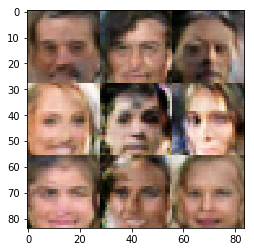

Epoch 1/1... Discriminator Loss: 0.9438... Generator Loss: 1.4684
Epoch 1/1... Discriminator Loss: 0.8458... Generator Loss: 1.8339
Epoch 1/1... Discriminator Loss: 0.6400... Generator Loss: 1.7678
Epoch 1/1... Discriminator Loss: 0.8931... Generator Loss: 2.0296
Epoch 1/1... Discriminator Loss: 0.8930... Generator Loss: 2.4680
Epoch 1/1... Discriminator Loss: 0.9383... Generator Loss: 2.0276
Epoch 1/1... Discriminator Loss: 0.9082... Generator Loss: 1.4177
Epoch 1/1... Discriminator Loss: 0.9611... Generator Loss: 1.0779
Epoch 1/1... Discriminator Loss: 0.9167... Generator Loss: 1.8038
Epoch 1/1... Discriminator Loss: 0.7877... Generator Loss: 1.1812


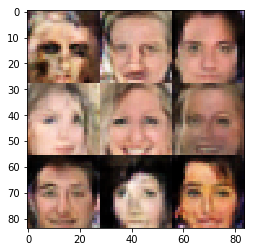

Epoch 1/1... Discriminator Loss: 0.8435... Generator Loss: 1.8034
Epoch 1/1... Discriminator Loss: 0.6715... Generator Loss: 1.7173
Epoch 1/1... Discriminator Loss: 0.8557... Generator Loss: 1.9660
Epoch 1/1... Discriminator Loss: 0.8066... Generator Loss: 1.9748
Epoch 1/1... Discriminator Loss: 0.8450... Generator Loss: 1.5338
Epoch 1/1... Discriminator Loss: 0.7461... Generator Loss: 2.1505
Epoch 1/1... Discriminator Loss: 0.8804... Generator Loss: 1.4548
Epoch 1/1... Discriminator Loss: 0.8997... Generator Loss: 1.3767
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 1.4307


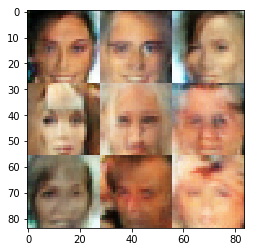

Epoch 1/1... Discriminator Loss: 0.9099... Generator Loss: 1.7277
Epoch 1/1... Discriminator Loss: 0.8385... Generator Loss: 1.5610
Epoch 1/1... Discriminator Loss: 0.7464... Generator Loss: 1.6029
Epoch 1/1... Discriminator Loss: 0.9756... Generator Loss: 1.2433
Epoch 1/1... Discriminator Loss: 0.7995... Generator Loss: 1.2399
Epoch 1/1... Discriminator Loss: 0.9596... Generator Loss: 1.4885
Epoch 1/1... Discriminator Loss: 0.8198... Generator Loss: 1.7617
Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 1.4941
Epoch 1/1... Discriminator Loss: 0.9671... Generator Loss: 1.1522
Epoch 1/1... Discriminator Loss: 0.8915... Generator Loss: 1.5896


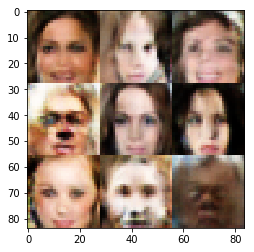

Epoch 1/1... Discriminator Loss: 0.8227... Generator Loss: 1.4092
Epoch 1/1... Discriminator Loss: 0.7803... Generator Loss: 1.2979
Epoch 1/1... Discriminator Loss: 0.9075... Generator Loss: 1.4214
Epoch 1/1... Discriminator Loss: 0.9925... Generator Loss: 0.9170
Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 0.8516... Generator Loss: 2.2571
Epoch 1/1... Discriminator Loss: 0.9133... Generator Loss: 1.1917
Epoch 1/1... Discriminator Loss: 0.9804... Generator Loss: 1.2352
Epoch 1/1... Discriminator Loss: 0.9335... Generator Loss: 1.4749
Epoch 1/1... Discriminator Loss: 0.7359... Generator Loss: 1.5611


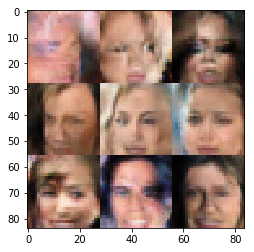

Epoch 1/1... Discriminator Loss: 0.8656... Generator Loss: 1.6502
Epoch 1/1... Discriminator Loss: 0.7622... Generator Loss: 1.6132
Epoch 1/1... Discriminator Loss: 0.8541... Generator Loss: 1.0162
Epoch 1/1... Discriminator Loss: 0.8723... Generator Loss: 1.5845
Epoch 1/1... Discriminator Loss: 0.8001... Generator Loss: 1.5656
Epoch 1/1... Discriminator Loss: 0.7851... Generator Loss: 1.1273
Epoch 1/1... Discriminator Loss: 0.7943... Generator Loss: 2.1118
Epoch 1/1... Discriminator Loss: 0.5561... Generator Loss: 2.1422
Epoch 1/1... Discriminator Loss: 0.7765... Generator Loss: 1.2959
Epoch 1/1... Discriminator Loss: 0.7902... Generator Loss: 1.9863


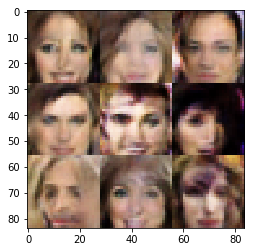

Epoch 1/1... Discriminator Loss: 0.9810... Generator Loss: 1.2224
Epoch 1/1... Discriminator Loss: 0.8184... Generator Loss: 2.1752
Epoch 1/1... Discriminator Loss: 0.6839... Generator Loss: 1.7714
Epoch 1/1... Discriminator Loss: 0.7783... Generator Loss: 1.5357
Epoch 1/1... Discriminator Loss: 0.7797... Generator Loss: 2.2674
Epoch 1/1... Discriminator Loss: 0.8163... Generator Loss: 1.6088
Epoch 1/1... Discriminator Loss: 1.0574... Generator Loss: 0.8526
Epoch 1/1... Discriminator Loss: 0.8800... Generator Loss: 1.9315
Epoch 1/1... Discriminator Loss: 0.7439... Generator Loss: 2.2762
Epoch 1/1... Discriminator Loss: 0.8286... Generator Loss: 1.4931


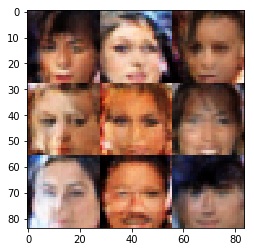

Epoch 1/1... Discriminator Loss: 1.0738... Generator Loss: 0.9459
Epoch 1/1... Discriminator Loss: 1.0418... Generator Loss: 1.1939
Epoch 1/1... Discriminator Loss: 0.9266... Generator Loss: 1.3333
Epoch 1/1... Discriminator Loss: 0.9777... Generator Loss: 1.2138
Epoch 1/1... Discriminator Loss: 0.7930... Generator Loss: 1.7003
Epoch 1/1... Discriminator Loss: 0.9224... Generator Loss: 1.5103
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 1.0029
Epoch 1/1... Discriminator Loss: 0.8359... Generator Loss: 1.1085
Epoch 1/1... Discriminator Loss: 0.6559... Generator Loss: 2.3066
Epoch 1/1... Discriminator Loss: 0.9024... Generator Loss: 1.0972


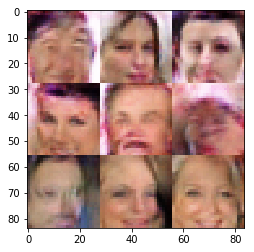

Epoch 1/1... Discriminator Loss: 0.7401... Generator Loss: 1.5555
Epoch 1/1... Discriminator Loss: 0.9899... Generator Loss: 1.1398
Epoch 1/1... Discriminator Loss: 0.7984... Generator Loss: 1.2801
Epoch 1/1... Discriminator Loss: 0.5996... Generator Loss: 2.0194
Epoch 1/1... Discriminator Loss: 0.9259... Generator Loss: 1.3234
Epoch 1/1... Discriminator Loss: 0.9805... Generator Loss: 1.7399
Epoch 1/1... Discriminator Loss: 0.8680... Generator Loss: 1.2627
Epoch 1/1... Discriminator Loss: 0.8780... Generator Loss: 1.6171
Epoch 1/1... Discriminator Loss: 0.9635... Generator Loss: 1.5127
Epoch 1/1... Discriminator Loss: 0.9425... Generator Loss: 1.7277


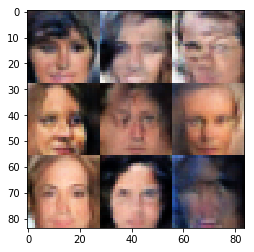

Epoch 1/1... Discriminator Loss: 0.7789... Generator Loss: 1.4282
Epoch 1/1... Discriminator Loss: 0.9077... Generator Loss: 1.2855
Epoch 1/1... Discriminator Loss: 0.9778... Generator Loss: 1.0421
Epoch 1/1... Discriminator Loss: 0.9075... Generator Loss: 1.2479
Epoch 1/1... Discriminator Loss: 0.6503... Generator Loss: 2.1220
Epoch 1/1... Discriminator Loss: 0.7180... Generator Loss: 2.2466
Epoch 1/1... Discriminator Loss: 0.8638... Generator Loss: 1.7965
Epoch 1/1... Discriminator Loss: 0.6885... Generator Loss: 1.3595
Epoch 1/1... Discriminator Loss: 0.7927... Generator Loss: 1.6861
Epoch 1/1... Discriminator Loss: 0.6945... Generator Loss: 1.7682


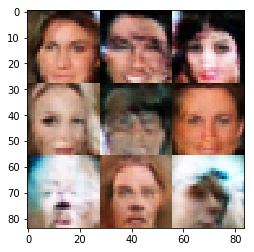

Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 0.6831... Generator Loss: 2.0771
Epoch 1/1... Discriminator Loss: 0.8127... Generator Loss: 2.0595
Epoch 1/1... Discriminator Loss: 0.7739... Generator Loss: 1.3596
Epoch 1/1... Discriminator Loss: 0.8907... Generator Loss: 1.2628
Epoch 1/1... Discriminator Loss: 0.8769... Generator Loss: 1.4308
Epoch 1/1... Discriminator Loss: 0.7710... Generator Loss: 1.9432
Epoch 1/1... Discriminator Loss: 0.9687... Generator Loss: 1.7448
Epoch 1/1... Discriminator Loss: 0.7529... Generator Loss: 1.1526
Epoch 1/1... Discriminator Loss: 0.8401... Generator Loss: 1.5063


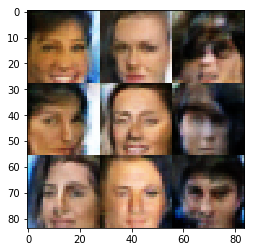

Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 1.1044
Epoch 1/1... Discriminator Loss: 0.7089... Generator Loss: 1.7297
Epoch 1/1... Discriminator Loss: 0.9808... Generator Loss: 1.3837
Epoch 1/1... Discriminator Loss: 0.7661... Generator Loss: 2.3025
Epoch 1/1... Discriminator Loss: 0.7110... Generator Loss: 1.6880
Epoch 1/1... Discriminator Loss: 0.8620... Generator Loss: 1.5510
Epoch 1/1... Discriminator Loss: 0.7257... Generator Loss: 2.0427
Epoch 1/1... Discriminator Loss: 0.8839... Generator Loss: 1.2566
Epoch 1/1... Discriminator Loss: 0.8741... Generator Loss: 1.3619
Epoch 1/1... Discriminator Loss: 0.7190... Generator Loss: 2.2497


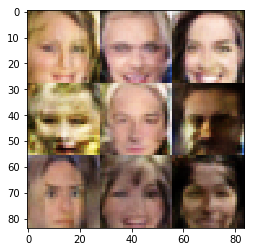

Epoch 1/1... Discriminator Loss: 0.8307... Generator Loss: 1.4069
Epoch 1/1... Discriminator Loss: 0.8549... Generator Loss: 1.4920
Epoch 1/1... Discriminator Loss: 0.8055... Generator Loss: 2.0488
Epoch 1/1... Discriminator Loss: 0.7317... Generator Loss: 1.5086
Epoch 1/1... Discriminator Loss: 0.8681... Generator Loss: 1.4089
Epoch 1/1... Discriminator Loss: 0.8444... Generator Loss: 1.6808
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 0.9805
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.7294
Epoch 1/1... Discriminator Loss: 0.6248... Generator Loss: 2.4072
Epoch 1/1... Discriminator Loss: 0.9909... Generator Loss: 1.2386


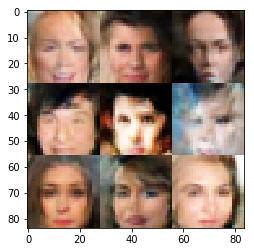

Epoch 1/1... Discriminator Loss: 0.9154... Generator Loss: 1.4391
Epoch 1/1... Discriminator Loss: 0.7370... Generator Loss: 2.3227
Epoch 1/1... Discriminator Loss: 0.8432... Generator Loss: 1.4726
Epoch 1/1... Discriminator Loss: 0.8694... Generator Loss: 1.5128
Epoch 1/1... Discriminator Loss: 0.8935... Generator Loss: 2.0463
Epoch 1/1... Discriminator Loss: 0.8047... Generator Loss: 2.1698
Epoch 1/1... Discriminator Loss: 0.8214... Generator Loss: 1.7962
Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 1.0123
Epoch 1/1... Discriminator Loss: 0.8883... Generator Loss: 1.0524
Epoch 1/1... Discriminator Loss: 0.9953... Generator Loss: 1.2087


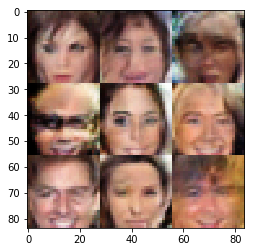

Epoch 1/1... Discriminator Loss: 0.9434... Generator Loss: 1.3855
Epoch 1/1... Discriminator Loss: 0.7655... Generator Loss: 1.7798
Epoch 1/1... Discriminator Loss: 0.8087... Generator Loss: 1.4032
Epoch 1/1... Discriminator Loss: 0.7533... Generator Loss: 1.5913
Epoch 1/1... Discriminator Loss: 0.8227... Generator Loss: 1.9641
Epoch 1/1... Discriminator Loss: 0.5731... Generator Loss: 2.6462
Epoch 1/1... Discriminator Loss: 0.7163... Generator Loss: 1.4728
Epoch 1/1... Discriminator Loss: 1.0355... Generator Loss: 1.4857
Epoch 1/1... Discriminator Loss: 0.7824... Generator Loss: 1.5479
Epoch 1/1... Discriminator Loss: 0.7820... Generator Loss: 2.5837


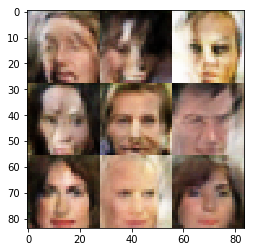

Epoch 1/1... Discriminator Loss: 0.5797... Generator Loss: 2.7440
Epoch 1/1... Discriminator Loss: 1.0972... Generator Loss: 1.1021
Epoch 1/1... Discriminator Loss: 0.7830... Generator Loss: 1.3712
Epoch 1/1... Discriminator Loss: 0.9174... Generator Loss: 1.5869
Epoch 1/1... Discriminator Loss: 0.8291... Generator Loss: 1.1912
Epoch 1/1... Discriminator Loss: 0.6964... Generator Loss: 2.2682
Epoch 1/1... Discriminator Loss: 1.0200... Generator Loss: 1.6487
Epoch 1/1... Discriminator Loss: 0.8688... Generator Loss: 1.9506
Epoch 1/1... Discriminator Loss: 0.8956... Generator Loss: 1.7255
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 0.9608


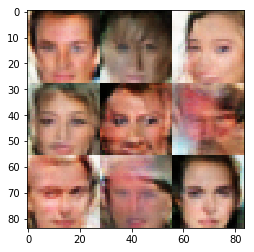

Epoch 1/1... Discriminator Loss: 0.8159... Generator Loss: 1.7166
Epoch 1/1... Discriminator Loss: 0.8419... Generator Loss: 1.9516
Epoch 1/1... Discriminator Loss: 0.7651... Generator Loss: 1.8063
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 0.9142... Generator Loss: 1.3333
Epoch 1/1... Discriminator Loss: 0.9861... Generator Loss: 1.1360
Epoch 1/1... Discriminator Loss: 0.9550... Generator Loss: 1.6106
Epoch 1/1... Discriminator Loss: 0.8124... Generator Loss: 1.4792
Epoch 1/1... Discriminator Loss: 0.9509... Generator Loss: 1.1458
Epoch 1/1... Discriminator Loss: 0.7479... Generator Loss: 2.3376


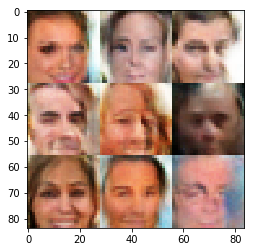

Epoch 1/1... Discriminator Loss: 0.8944... Generator Loss: 1.1431
Epoch 1/1... Discriminator Loss: 0.7035... Generator Loss: 1.5434
Epoch 1/1... Discriminator Loss: 0.6939... Generator Loss: 1.8398
Epoch 1/1... Discriminator Loss: 0.6246... Generator Loss: 2.8343
Epoch 1/1... Discriminator Loss: 0.7860... Generator Loss: 1.4984
Epoch 1/1... Discriminator Loss: 0.9846... Generator Loss: 0.9434
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 1.0238
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 0.9962
Epoch 1/1... Discriminator Loss: 0.8661... Generator Loss: 1.3075
Epoch 1/1... Discriminator Loss: 0.8113... Generator Loss: 1.9210


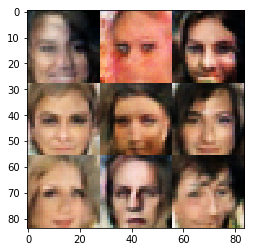

Epoch 1/1... Discriminator Loss: 0.8892... Generator Loss: 1.2251
Epoch 1/1... Discriminator Loss: 0.7167... Generator Loss: 1.6692
Epoch 1/1... Discriminator Loss: 0.8423... Generator Loss: 1.4921
Epoch 1/1... Discriminator Loss: 0.9640... Generator Loss: 1.4946
Epoch 1/1... Discriminator Loss: 0.8276... Generator Loss: 1.7938
Epoch 1/1... Discriminator Loss: 0.9220... Generator Loss: 1.4226
Epoch 1/1... Discriminator Loss: 0.7706... Generator Loss: 1.9784
Epoch 1/1... Discriminator Loss: 0.9664... Generator Loss: 2.4054
Epoch 1/1... Discriminator Loss: 0.9038... Generator Loss: 0.9732
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 1.1593


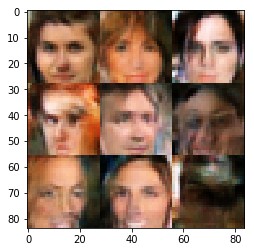

Epoch 1/1... Discriminator Loss: 0.7897... Generator Loss: 1.6116
Epoch 1/1... Discriminator Loss: 0.8253... Generator Loss: 1.6988
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 0.9518
Epoch 1/1... Discriminator Loss: 0.9225... Generator Loss: 1.7309
Epoch 1/1... Discriminator Loss: 0.8035... Generator Loss: 1.8138
Epoch 1/1... Discriminator Loss: 0.7940... Generator Loss: 1.9149
Epoch 1/1... Discriminator Loss: 0.7277... Generator Loss: 1.6983
Epoch 1/1... Discriminator Loss: 0.9117... Generator Loss: 1.5306
Epoch 1/1... Discriminator Loss: 0.8217... Generator Loss: 1.5707
Epoch 1/1... Discriminator Loss: 0.8572... Generator Loss: 1.3835


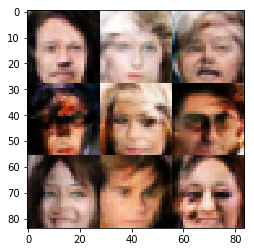

Epoch 1/1... Discriminator Loss: 0.6279... Generator Loss: 1.8062
Epoch 1/1... Discriminator Loss: 0.7790... Generator Loss: 1.7495
Epoch 1/1... Discriminator Loss: 1.0865... Generator Loss: 1.1696
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 1.3201
Epoch 1/1... Discriminator Loss: 0.9292... Generator Loss: 1.5059
Epoch 1/1... Discriminator Loss: 0.9558... Generator Loss: 1.7448
Epoch 1/1... Discriminator Loss: 0.7339... Generator Loss: 1.4227
Epoch 1/1... Discriminator Loss: 0.6975... Generator Loss: 2.0844
Epoch 1/1... Discriminator Loss: 0.8423... Generator Loss: 1.5143
Epoch 1/1... Discriminator Loss: 0.7971... Generator Loss: 1.8477


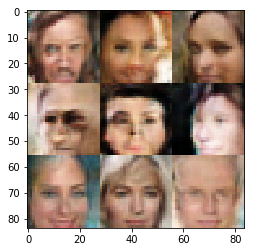

Epoch 1/1... Discriminator Loss: 0.6873... Generator Loss: 1.8028
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 1.0328
Epoch 1/1... Discriminator Loss: 0.6719... Generator Loss: 1.9686
Epoch 1/1... Discriminator Loss: 0.7055... Generator Loss: 1.6567
Epoch 1/1... Discriminator Loss: 0.7976... Generator Loss: 2.0272
Epoch 1/1... Discriminator Loss: 0.8565... Generator Loss: 1.4744
Epoch 1/1... Discriminator Loss: 0.7692... Generator Loss: 1.8018
Epoch 1/1... Discriminator Loss: 0.7411... Generator Loss: 1.6791
Epoch 1/1... Discriminator Loss: 0.7169... Generator Loss: 2.0020
Epoch 1/1... Discriminator Loss: 0.8010... Generator Loss: 1.6246


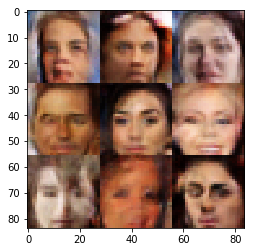

Epoch 1/1... Discriminator Loss: 0.8987... Generator Loss: 2.5299
Epoch 1/1... Discriminator Loss: 0.7657... Generator Loss: 1.7873
Epoch 1/1... Discriminator Loss: 0.7046... Generator Loss: 2.3265
Epoch 1/1... Discriminator Loss: 0.7549... Generator Loss: 1.5053
Epoch 1/1... Discriminator Loss: 0.7355... Generator Loss: 2.1965
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 1.1726
Epoch 1/1... Discriminator Loss: 0.6791... Generator Loss: 1.3200
Epoch 1/1... Discriminator Loss: 0.8092... Generator Loss: 1.3626
Epoch 1/1... Discriminator Loss: 0.6633... Generator Loss: 2.0521
Epoch 1/1... Discriminator Loss: 1.1104... Generator Loss: 1.0204


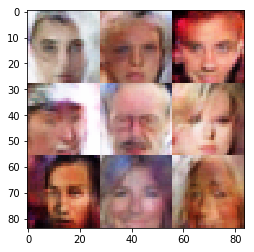

Epoch 1/1... Discriminator Loss: 0.9317... Generator Loss: 1.6992
Epoch 1/1... Discriminator Loss: 0.6584... Generator Loss: 1.6583
Epoch 1/1... Discriminator Loss: 0.8096... Generator Loss: 1.4619
Epoch 1/1... Discriminator Loss: 0.7271... Generator Loss: 1.3518
Epoch 1/1... Discriminator Loss: 0.7346... Generator Loss: 1.7513
Epoch 1/1... Discriminator Loss: 0.7820... Generator Loss: 1.3391
Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 1.3044
Epoch 1/1... Discriminator Loss: 0.9219... Generator Loss: 1.4581
Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 1.2077
Epoch 1/1... Discriminator Loss: 0.7473... Generator Loss: 1.5245


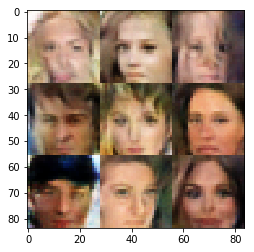

Epoch 1/1... Discriminator Loss: 0.7927... Generator Loss: 1.6173
Epoch 1/1... Discriminator Loss: 0.9315... Generator Loss: 1.4513
Epoch 1/1... Discriminator Loss: 0.9271... Generator Loss: 1.5167
Epoch 1/1... Discriminator Loss: 0.9431... Generator Loss: 2.2280
Epoch 1/1... Discriminator Loss: 0.7948... Generator Loss: 1.6716
Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 1.1436
Epoch 1/1... Discriminator Loss: 0.8195... Generator Loss: 1.7905
Epoch 1/1... Discriminator Loss: 0.7399... Generator Loss: 1.8640
Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 1.2585
Epoch 1/1... Discriminator Loss: 0.8586... Generator Loss: 1.3856


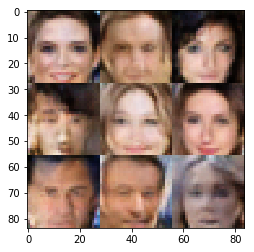

Epoch 1/1... Discriminator Loss: 0.7988... Generator Loss: 2.0029
Epoch 1/1... Discriminator Loss: 0.8509... Generator Loss: 2.2047
Epoch 1/1... Discriminator Loss: 0.7004... Generator Loss: 1.7746
Epoch 1/1... Discriminator Loss: 0.7710... Generator Loss: 1.4859
Epoch 1/1... Discriminator Loss: 0.9415... Generator Loss: 1.7431
Epoch 1/1... Discriminator Loss: 0.7198... Generator Loss: 1.3999
Epoch 1/1... Discriminator Loss: 0.7622... Generator Loss: 1.9553
Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 1.5866
Epoch 1/1... Discriminator Loss: 0.7239... Generator Loss: 1.9704
Epoch 1/1... Discriminator Loss: 0.8036... Generator Loss: 1.8305


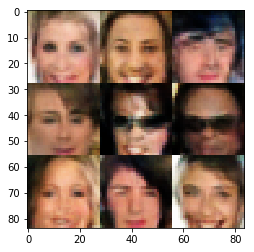

Epoch 1/1... Discriminator Loss: 0.8124... Generator Loss: 1.5403
Epoch 1/1... Discriminator Loss: 0.9304... Generator Loss: 1.5541
Epoch 1/1... Discriminator Loss: 0.8975... Generator Loss: 2.0104
Epoch 1/1... Discriminator Loss: 0.6907... Generator Loss: 1.6312
Epoch 1/1... Discriminator Loss: 0.9660... Generator Loss: 1.4732
Epoch 1/1... Discriminator Loss: 0.9148... Generator Loss: 1.7737
Epoch 1/1... Discriminator Loss: 0.7228... Generator Loss: 1.8880
Epoch 1/1... Discriminator Loss: 0.9316... Generator Loss: 1.2779
Epoch 1/1... Discriminator Loss: 1.0097... Generator Loss: 1.0732
Epoch 1/1... Discriminator Loss: 0.6631... Generator Loss: 1.9175


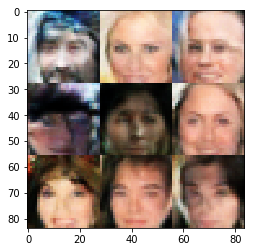

Epoch 1/1... Discriminator Loss: 0.7817... Generator Loss: 1.8805
Epoch 1/1... Discriminator Loss: 0.8227... Generator Loss: 1.8442
Epoch 1/1... Discriminator Loss: 0.7418... Generator Loss: 1.6936
Epoch 1/1... Discriminator Loss: 0.8669... Generator Loss: 1.0714
Epoch 1/1... Discriminator Loss: 0.7396... Generator Loss: 2.3528
Epoch 1/1... Discriminator Loss: 0.8230... Generator Loss: 1.7253
Epoch 1/1... Discriminator Loss: 0.9659... Generator Loss: 1.6973
Epoch 1/1... Discriminator Loss: 0.8643... Generator Loss: 1.6044
Epoch 1/1... Discriminator Loss: 0.8077... Generator Loss: 1.2398
Epoch 1/1... Discriminator Loss: 0.8230... Generator Loss: 1.5033


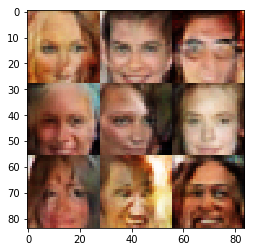

Epoch 1/1... Discriminator Loss: 0.7454... Generator Loss: 1.8988
Epoch 1/1... Discriminator Loss: 1.0207... Generator Loss: 1.1096
Epoch 1/1... Discriminator Loss: 0.9379... Generator Loss: 1.5691
Epoch 1/1... Discriminator Loss: 0.8302... Generator Loss: 1.3152
Epoch 1/1... Discriminator Loss: 0.9460... Generator Loss: 1.1384
Epoch 1/1... Discriminator Loss: 0.7887... Generator Loss: 1.5551
Epoch 1/1... Discriminator Loss: 0.7216... Generator Loss: 1.4333
Epoch 1/1... Discriminator Loss: 0.8829... Generator Loss: 1.3349
Epoch 1/1... Discriminator Loss: 1.1195... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 0.7858... Generator Loss: 1.5950


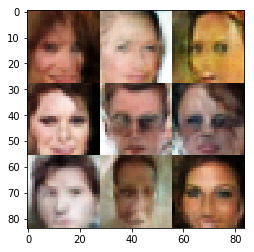

Epoch 1/1... Discriminator Loss: 0.9387... Generator Loss: 1.2279
Epoch 1/1... Discriminator Loss: 0.6573... Generator Loss: 1.7219
Epoch 1/1... Discriminator Loss: 0.6842... Generator Loss: 2.0978
Epoch 1/1... Discriminator Loss: 0.7945... Generator Loss: 1.8998
Epoch 1/1... Discriminator Loss: 1.0847... Generator Loss: 1.0447
Epoch 1/1... Discriminator Loss: 0.8497... Generator Loss: 1.6052
Epoch 1/1... Discriminator Loss: 0.7427... Generator Loss: 1.6628
Epoch 1/1... Discriminator Loss: 0.7484... Generator Loss: 1.5166
Epoch 1/1... Discriminator Loss: 0.9485... Generator Loss: 1.1702
Epoch 1/1... Discriminator Loss: 0.8683... Generator Loss: 1.4084


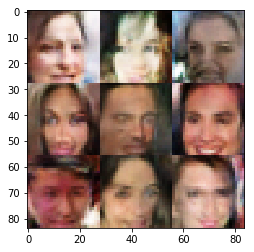

Epoch 1/1... Discriminator Loss: 0.6586... Generator Loss: 2.9798
Epoch 1/1... Discriminator Loss: 0.8736... Generator Loss: 1.3441
Epoch 1/1... Discriminator Loss: 0.8405... Generator Loss: 1.2139
Epoch 1/1... Discriminator Loss: 0.7247... Generator Loss: 1.8192
Epoch 1/1... Discriminator Loss: 0.8917... Generator Loss: 2.2493
Epoch 1/1... Discriminator Loss: 0.8018... Generator Loss: 2.0002
Epoch 1/1... Discriminator Loss: 0.7758... Generator Loss: 1.4206
Epoch 1/1... Discriminator Loss: 0.8558... Generator Loss: 1.6971
Epoch 1/1... Discriminator Loss: 0.6775... Generator Loss: 1.8940
Epoch 1/1... Discriminator Loss: 0.8694... Generator Loss: 1.3705


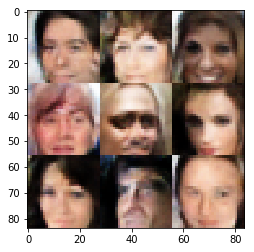

Epoch 1/1... Discriminator Loss: 0.8337... Generator Loss: 1.6319
Epoch 1/1... Discriminator Loss: 0.8346... Generator Loss: 1.2799
Epoch 1/1... Discriminator Loss: 0.8712... Generator Loss: 1.2426
Epoch 1/1... Discriminator Loss: 0.6154... Generator Loss: 2.4395
Epoch 1/1... Discriminator Loss: 0.7731... Generator Loss: 1.3240
Epoch 1/1... Discriminator Loss: 0.8274... Generator Loss: 1.4861
Epoch 1/1... Discriminator Loss: 1.0241... Generator Loss: 1.1262
Epoch 1/1... Discriminator Loss: 0.8541... Generator Loss: 2.3704
Epoch 1/1... Discriminator Loss: 0.8061... Generator Loss: 2.1658
Epoch 1/1... Discriminator Loss: 0.7432... Generator Loss: 1.3864


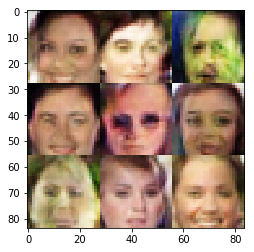

Epoch 1/1... Discriminator Loss: 0.8816... Generator Loss: 1.7125
Epoch 1/1... Discriminator Loss: 0.9977... Generator Loss: 1.1881
Epoch 1/1... Discriminator Loss: 0.7820... Generator Loss: 1.9037


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.